# Estudio del consumo eléctrico en UK desde 2009 hasta 2024

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from prophet import Prophet
import shap
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [38]:
url = 'https://proyectobloque2itbd.s3.us-east-1.amazonaws.com/historic_demand_2009_2024.csv'
df2 = pd.read_csv(url)

## 1. Descripción de los datos y preprocesamiento

Nos quedamos con las variables que nos interesan.

In [39]:
df = df2[["settlement_date",
          "settlement_period",
          "nd",
          "tsd",
          "england_wales_demand",
          "embedded_wind_generation",
          "embedded_wind_capacity",
          "embedded_solar_generation",
          "embedded_solar_capacity",
          "is_holiday"]]

In [40]:
df.head()

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,1


#### Descripción de las variables:

1. ${settlement\_date}$: fecha del registros en formato en ${yyyy/mm/dd}$.
2. ${settlement\_period}$: periodo de día en que se toma el registro. Se realizan 48 registros por día (cada media hora).
3. ${nd}$: demanda eléctrica nacional, medida en MW.
4. ${tsd}$: demanda eléctrica nacional a la que se le suma la carga de estaciones generadoras, el bombeo de almacenamiento hidroeléctrico y exportaciones por interconectores.
5. ${england\_wales\_demand}$: demanda eléctrica de Iglaterra y Gales (sin Escocia).
6. ${embedded\_wind\_generation}$: estimación de la generación de energía eólica distribuida.
7. ${embedded\_wind\_capacity}$: capacidad instalada de generación de energía eólica distribuida.
8. ${embedded\_solar\_generation}$: estimación de la generación de energía solar distribuida.
9. ${embedded\_solar\_capacity}$: capacidad instalada de generación de energía solar distribuida.
10. ${is\_holiday}$: variable booleana (0/1) que indica si el día es festivo nacional.

#### Tamaño del conjunto de datos

In [41]:
df.shape

(279264, 10)

Contamos con 10 variables y 279264 filas de datos.

#### Comprobación de tipo de variable y valores nulos

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279264 entries, 0 to 279263
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   settlement_date            279264 non-null  object
 1   settlement_period          279264 non-null  int64 
 2   nd                         279264 non-null  int64 
 3   tsd                        279264 non-null  int64 
 4   england_wales_demand       279264 non-null  int64 
 5   embedded_wind_generation   279264 non-null  int64 
 6   embedded_wind_capacity     279264 non-null  int64 
 7   embedded_solar_generation  279264 non-null  int64 
 8   embedded_solar_capacity    279264 non-null  int64 
 9   is_holiday                 279264 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 21.3+ MB


Comprobamos que ninguna variable tiene valores nulos. Además, observamos que tenemos una variable objeto y nueve variables de enteros.

#### Comprobación de momentos temporales duplicados

Comprobamos si hay momentos temporales duplicados (fecha y periodo conjuntos)

In [43]:
duplicados = df[df.duplicated(subset=["settlement_date", "settlement_period"], keep=False)]
print("Número de momentos temporales duplicados:", duplicados.shape[0])

Número de momentos temporales duplicados: 0


Añadimos las variables ${year}$, ${month}$ y ${day\_of\_week}$, ya que las usaremos para la visualización de datos.

In [44]:
# Nos aseguramos de que la columna sea datetime
df["settlement_date"] = pd.to_datetime(df["settlement_date"])

df["day_of_week"] = df["settlement_date"].dt.day_name()
df["month"] = df["settlement_date"].dt.month_name()
df['year'] = df['settlement_date'].dt.year

/tmp/ipython-input-176988415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["settlement_date"] = pd.to_datetime(df["settlement_date"])
/tmp/ipython-input-176988415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["day_of_week"] = df["settlement_date"].dt.day_name()
/tmp/ipython-input-176988415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Añadimos la variable ${ds}$ para identificar cada momento temporal; es decir, para juntar ${settlement\_date}$ y ${settlement\_period}$.

In [45]:
df["ds"] = df["settlement_date"] + pd.to_timedelta((df["settlement_period"]-1)*30, unit='m')

/tmp/ipython-input-2920750442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ds"] = df["settlement_date"] + pd.to_timedelta((df["settlement_period"]-1)*30, unit='m')


Agrupamos los datos por día, semana, mes y año para análisis siguientes. La agrupación la hacemos sumando los datos de consumo; es decir, si la agrupación es por días, sumamos el consumo de cada momento del día. Idem para el resto de agrupaciones. En el caso de la variable ${is\_holiday}$, dividimos entre 48 para que saber el número exacto de festivos por agrupación.

Además, realizamos otra serie de tratamientos para las visualizaciones siguientes.

In [46]:
# Agrupación diaria
df_diario = (
    df.resample("D", on="settlement_date")
      .sum(numeric_only=True)
      .reset_index()
)
df_diario["day"] = df_diario["settlement_date"].dt.strftime("%Y-%m-%d")

# Agrupación semanal
df_semanal = (
    df.resample("W", on="settlement_date")
      .sum(numeric_only=True)
      .reset_index()
)
df_semanal["week"] = df_semanal["settlement_date"].dt.strftime("%Y-W%U")

# Agrupación mensual
df_mensual = (
    df.resample("M", on="settlement_date")
      .sum(numeric_only=True)
      .reset_index()
)
df_mensual["month"] = df_mensual["settlement_date"].dt.to_period("M").astype(str)

# Agrupación mensual

df_anual = (
    df.drop(columns=["year"])
      .resample("Y", on="settlement_date")
      .sum(numeric_only=True)
      .reset_index()
)
df_anual["year"] = df_anual["settlement_date"].dt.year

# Dividimos la columna 'is_holiday' entre 48
df_mensual["is_holiday"] = df_mensual["is_holiday"] / 48
df_anual["is_holiday"] = df_anual["is_holiday"] / 48
df_semanal["is_holiday"] = df_semanal["is_holiday"] / 48
df_diario["is_holiday"] = df_diario["is_holiday"] / 48

# Creamos una nueva columna que sume la generación eólica y solar
df_anual["Eolica_Solar"] = df_anual["embedded_wind_generation"] + df_anual["embedded_solar_generation"]

# Creamos las columnas de mes y día de la semana en el dataframe diario
df_diario["month"] = df_diario["settlement_date"].dt.month_name()
df_diario["day_of_week"] = df_diario["settlement_date"].dt.day_name()

# Añadimos una columna con el nombre del mes al dataframe diario
df_diario["month"] = df_diario["settlement_date"].dt.month_name()

# Ordenamos los meses por orden cronológico
meses_ordenados = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
df_diario["month"] = pd.Categorical(df_diario["month"], categories=meses_ordenados, ordered=True)

# Convertimos is_holiday a una variable boolean Sí/No
df_diario["festivo"] = df_diario["is_holiday"].map({0: "No", 1: "Sí"})

# Añadimos las columnas de año y semana a l dataframe diario
df_diario["year"] = df_diario["settlement_date"].dt.year
df_diario["week"] = df_diario["settlement_date"].dt.isocalendar().week

/tmp/ipython-input-3582869090.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample("M", on="settlement_date")
/tmp/ipython-input-3582869090.py:29: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y", on="settlement_date")


Comprobamos si hay valores de 0 en la demanda nacional ${tsd}$ y en Inglaterra y Gales.

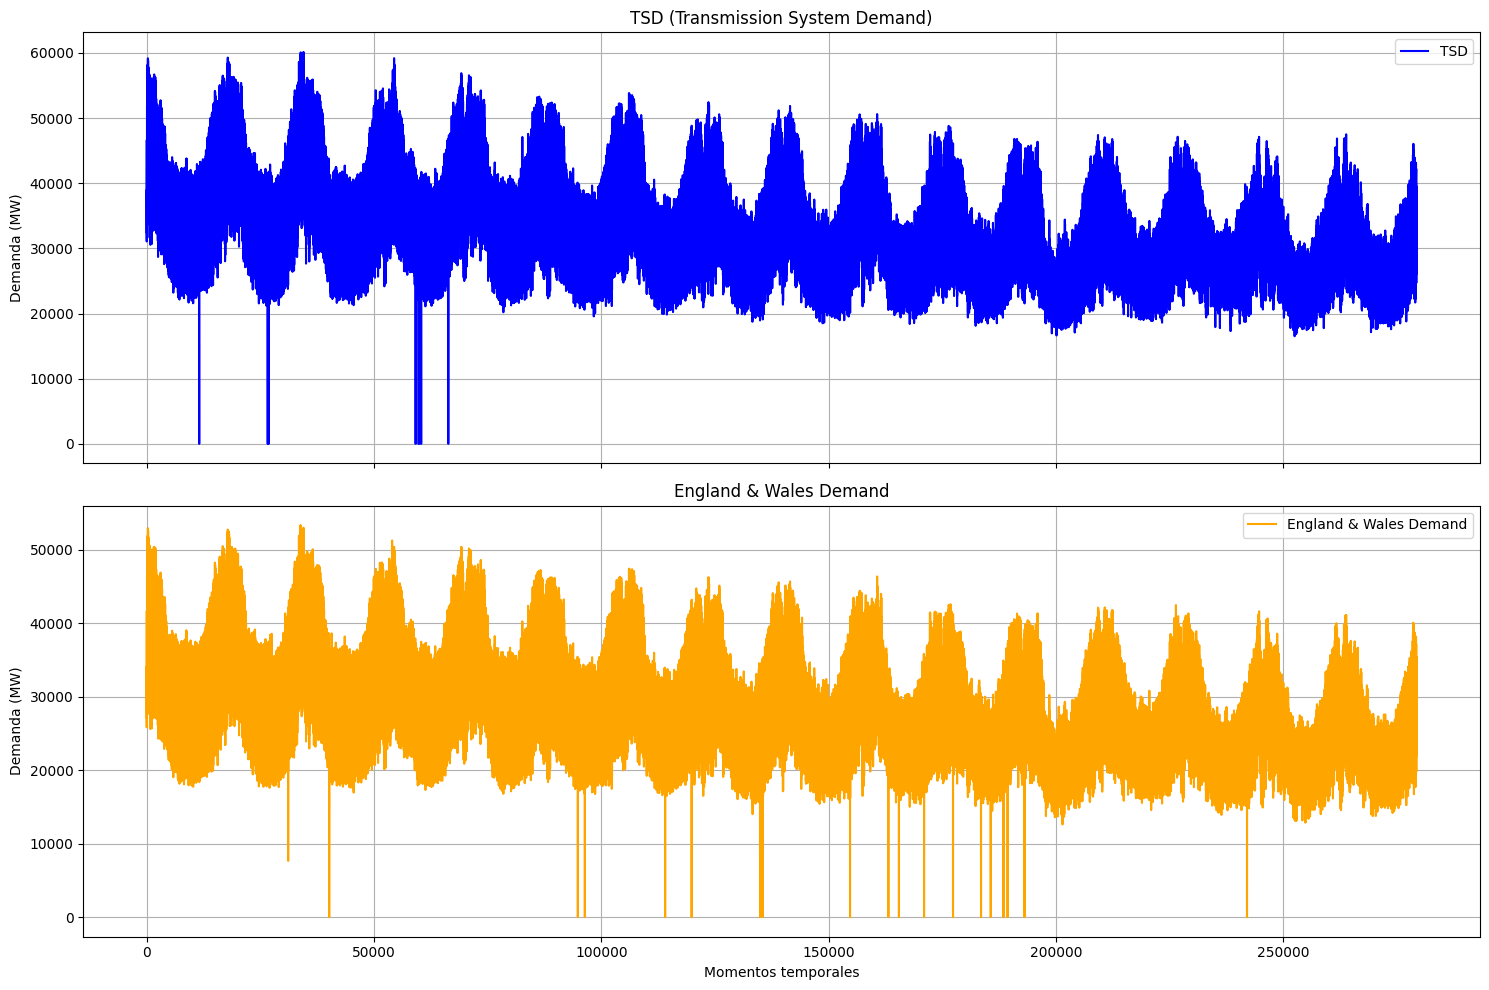

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Gráfica tsd
axes[0].plot(df["tsd"], color='blue', label='TSD')
axes[0].set_title("TSD (Transmission System Demand)")
axes[0].set_ylabel("Demanda (MW)")
axes[0].grid(True)
axes[0].legend()

# Gráfica england_wales_demand
axes[1].plot(df["england_wales_demand"], color='orange', label='England & Wales Demand')
axes[1].set_title("England & Wales Demand")
axes[1].set_xlabel("Momentos temporales")
axes[1].set_ylabel("Demanda (MW)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

Como hay momentos en que la demanda nacional en todo UK y en Inglaterra y Gales son 0, los vamos a sustituir ya que se consideran valores anómalos y estroperían la métrica de error MAPE que usaremos más adelante.

Los vamos a sustituir por interpolación lineal porque asume que los valores anómalos (ceros) se comportan como una transición suave entre los valores anteriores y posteriores.

In [48]:
def replace_zeros_with_avg(series):
    series = series.copy()
    series = series.replace(0, np.nan)
    series = series.interpolate(method='linear')
    series = series.fillna(method='bfill').fillna(method='ffill')
    return series

In [49]:
df["tsd"] = replace_zeros_with_avg(df["tsd"])
df["england_wales_demand"] = replace_zeros_with_avg(df["england_wales_demand"])

/tmp/ipython-input-2443881125.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-1944552714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tsd"] = replace_zeros_with_avg(df["tsd"])
/tmp/ipython-input-1944552714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["england_wales_demand"] = replace_zeros_with_avg(df["england_wales

Comprobamos que ya no aparecen ceros en las demandas eléctricas.

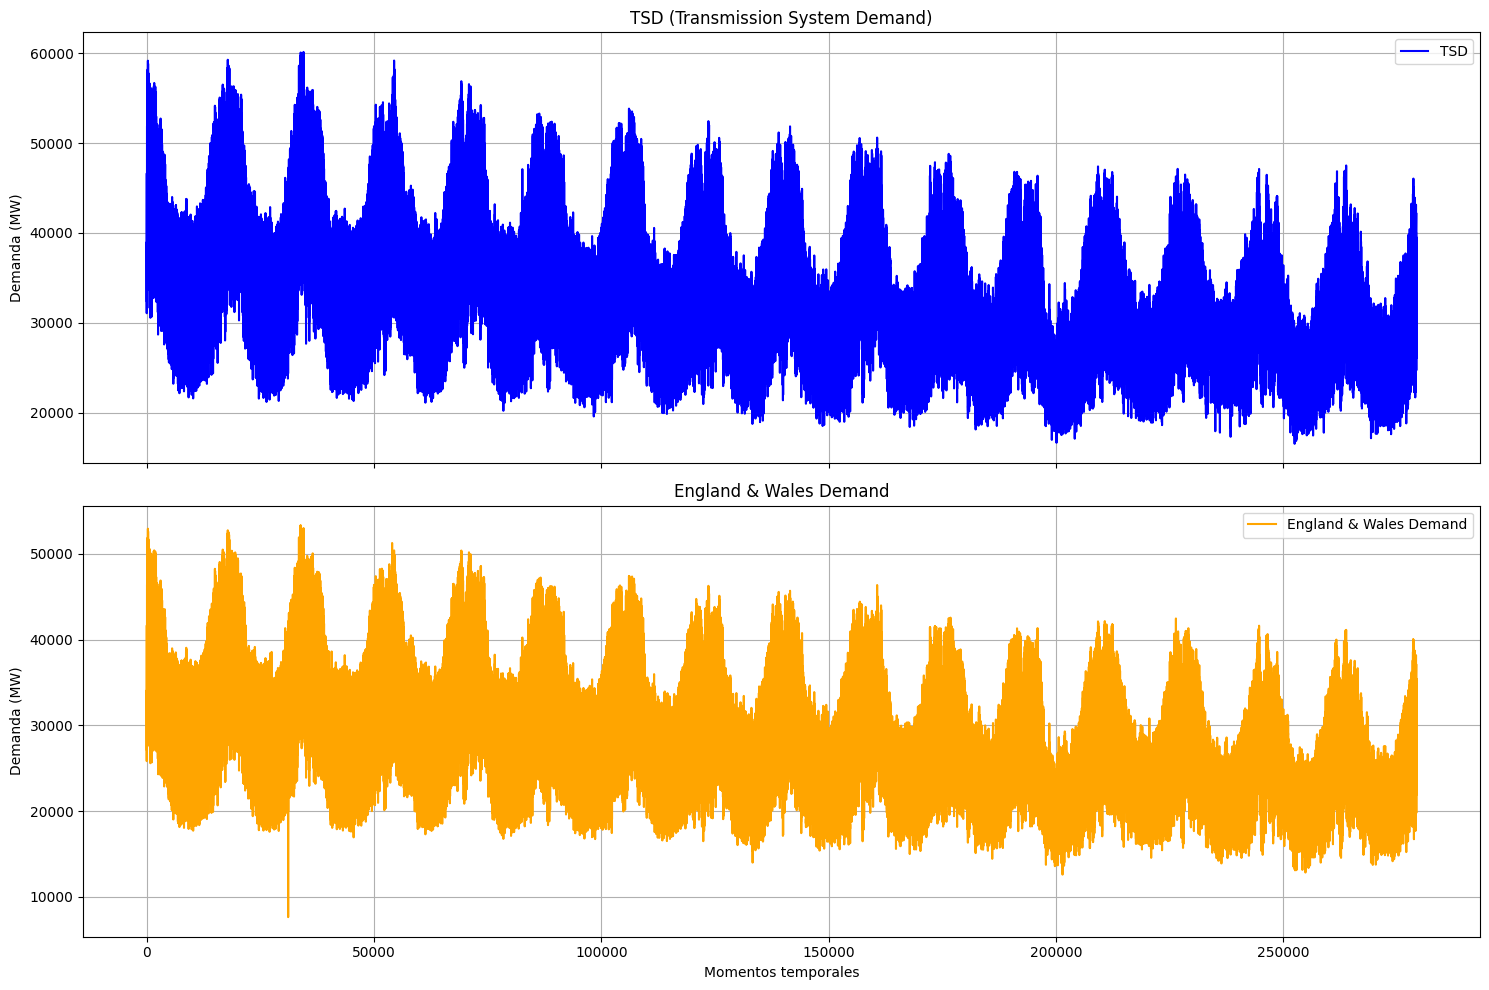

In [50]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Gráfica tsd
axes[0].plot(df["tsd"], color='blue', label='TSD')
axes[0].set_title("TSD (Transmission System Demand)")
axes[0].set_ylabel("Demanda (MW)")
axes[0].grid(True)
axes[0].legend()

# Gráfica england_wales_demand
axes[1].plot(df["england_wales_demand"], color='orange', label='England & Wales Demand')
axes[1].set_title("England & Wales Demand")
axes[1].set_xlabel("Momentos temporales")
axes[1].set_ylabel("Demanda (MW)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

## 2. Visualización de los datos

### 2.1 Características generales

#### Gráfico de tendencia

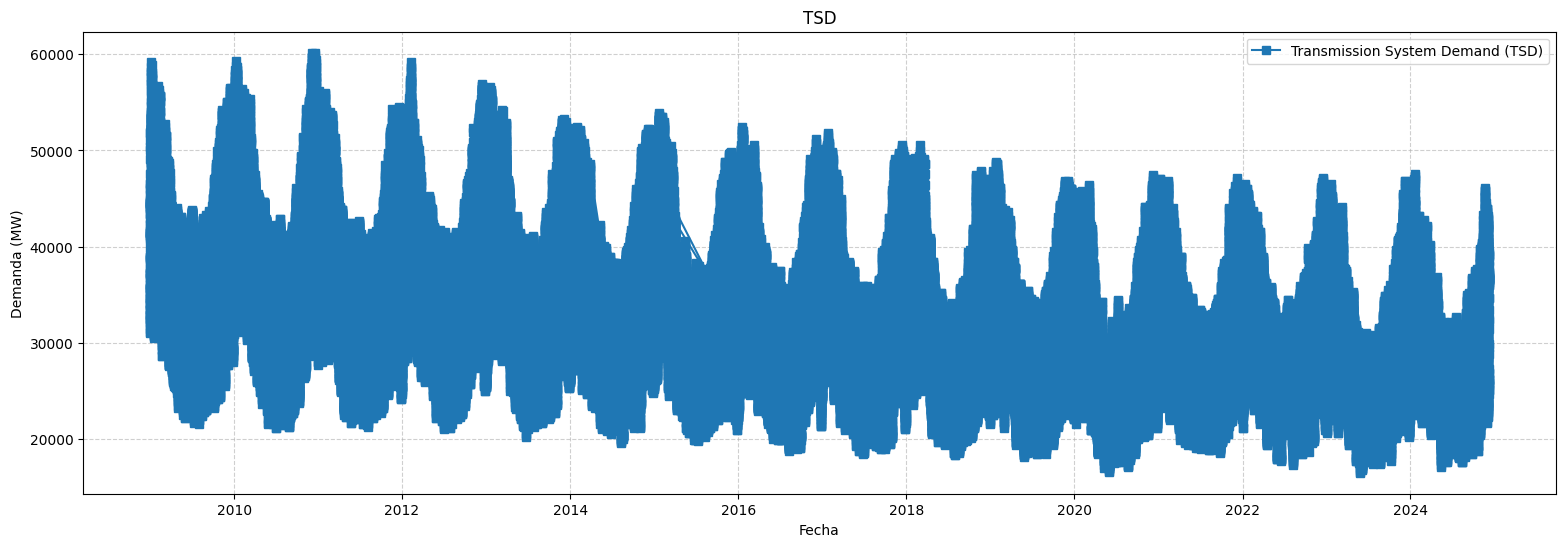

In [51]:
plt.figure(figsize=(19,6))
plt.plot(df["ds"], df["tsd"], marker="s", label="Transmission System Demand (TSD)")
plt.xlabel("Fecha")
plt.ylabel("Demanda (MW)")
plt.title("TSD")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Observamos que los datos siguen una tendencia lineal descendiente; es decir, la demanda eléctrica tiende a disminuir con el paso del tiempo de manera lineal, sin cambios bruscos ni picos repentinos. Además, se aprecia una estacionalidad anual.

#### Comparación de la demanda nacional con la total

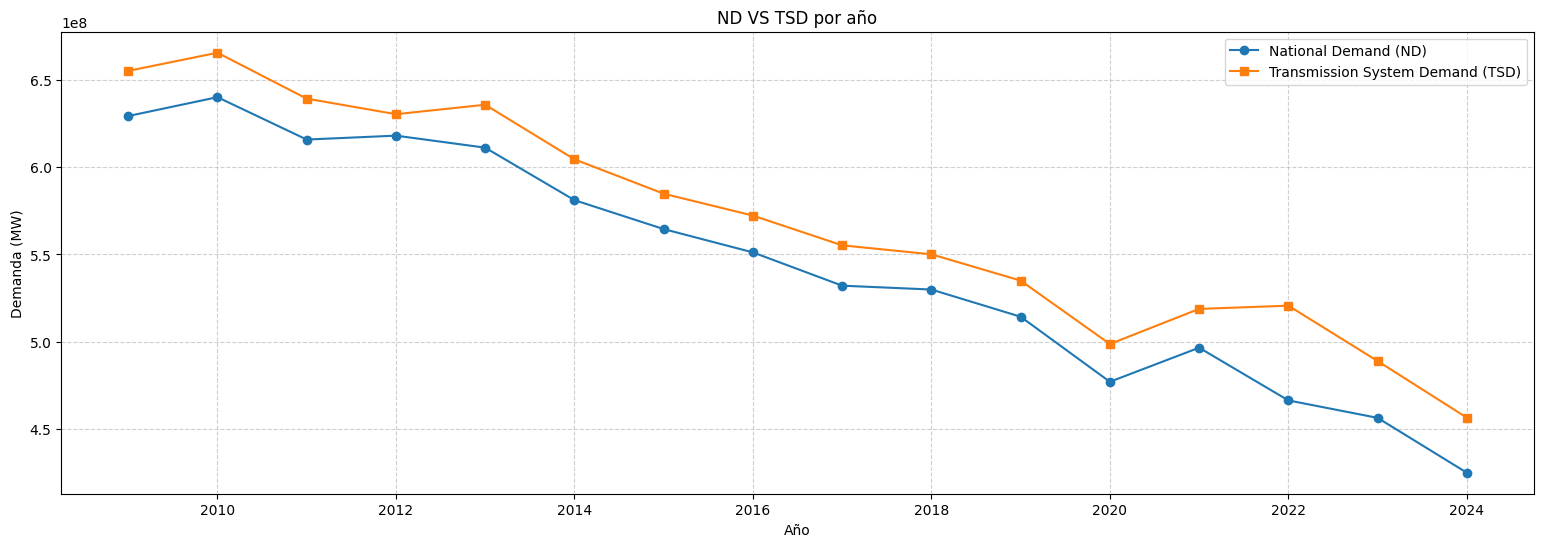

In [52]:
plt.figure(figsize=(19,6))
plt.plot(df_anual["year"], df_anual["nd"], marker="o", label="National Demand (ND)")
plt.plot(df_anual["year"], df_anual["tsd"], marker="s", label="Transmission System Demand (TSD)")
plt.xlabel("Año")
plt.ylabel("Demanda (MW)")
plt.title("ND VS TSD por año")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Hemos graficado tanto la demanda nacional como la total, por años. Observamos que ambas demandas siguen la misma tendencia decreciente en general.
Claramente, la demanda total está por encima de la demanda nacional, pero la diferencia entre ambas es bastante significativa, teniendo una diferencia media de 25 millones de MW.

In [53]:
# Diferencia de tsd - nd por año
tabla_diferencias = (
    df.resample("Y", on="settlement_date")[["tsd", "nd"]]
      .sum()
      .assign(Diferencia=lambda x: x["tsd"] - x["nd"])
      .assign(Año=lambda x: x.index.year)[["Año", "Diferencia"]]
)

media_diferencia = tabla_diferencias["Diferencia"].mean()

print(tabla_diferencias.to_string(index=False))
print(f"La media de la diferencia entre tsd y nd es: {media_diferencia:.2f}")

 Año  Diferencia
2009  27028522.0
2010  28113265.0
2011  23441564.0
2012  21128333.5
2013  24581504.0
2014  23388110.0
2015  20261584.0
2016  21083531.0
2017  23098051.0
2018  20181357.0
2019  20691648.0
2020  21629288.0
2021  22217840.0
2022  54259807.0
2023  32534075.0
2024  31519720.0
La media de la diferencia entre tsd y nd es: 25947387.47


/tmp/ipython-input-245302650.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.resample("Y", on="settlement_date")[["tsd", "nd"]]


#### Comparación entre el primer y último año de la demanda eléctrica por año

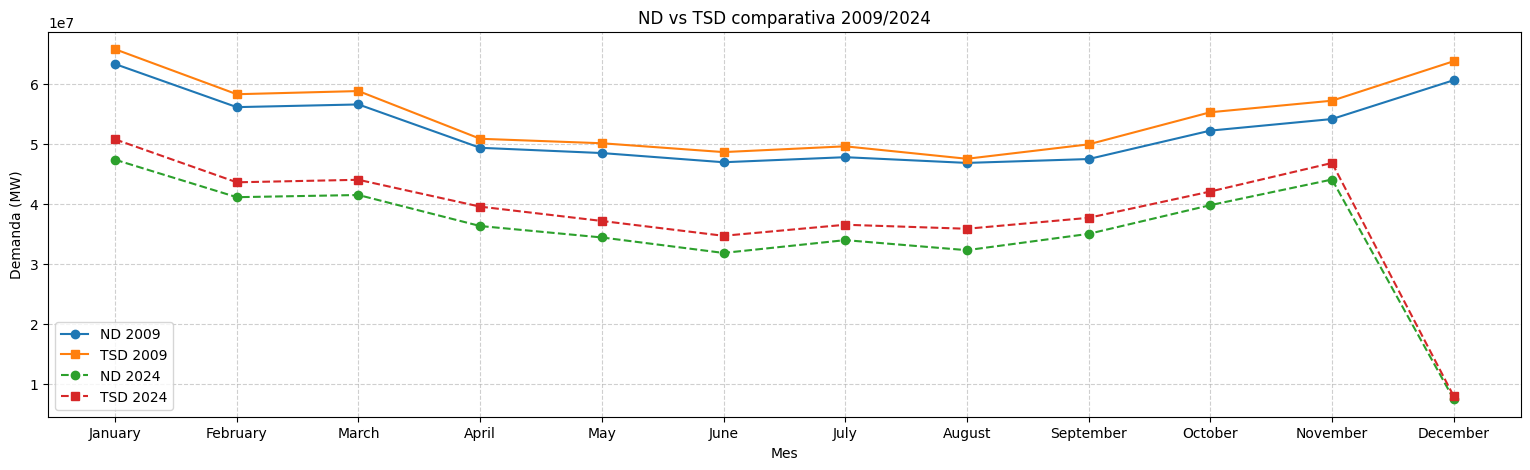

In [54]:
primer_año = df_mensual["settlement_date"].dt.year.min()
ultimo_año = df_mensual["settlement_date"].dt.year.max()

# Filtramos por año y creamos las columnas 'year' y 'Mes_num'
df_filtrado_2009 = df_mensual[df_mensual["settlement_date"].dt.year == primer_año].copy()
df_filtrado_2009["Mes_num"] = df_filtrado_2009["settlement_date"].dt.month

df_filtrado_2024 = df_mensual[df_mensual["settlement_date"].dt.year == ultimo_año].copy()
df_filtrado_2024["Mes_num"] = df_filtrado_2024["settlement_date"].dt.month

# Graficamos
plt.figure(figsize=(19,5))
plt.plot(df_filtrado_2009["Mes_num"], df_filtrado_2009["nd"], marker="o", label=f"ND {primer_año}")
plt.plot(df_filtrado_2009["Mes_num"], df_filtrado_2009["tsd"], marker="s", label=f"TSD {primer_año}")
plt.plot(df_filtrado_2024["Mes_num"], df_filtrado_2024["nd"], marker="o", linestyle="--", label=f"ND {ultimo_año}")
plt.plot(df_filtrado_2024["Mes_num"], df_filtrado_2024["tsd"], marker="s", linestyle="--", label=f"TSD {ultimo_año}")
plt.xlabel("Mes")
plt.ylabel("Demanda (MW)")
plt.title(f"ND vs TSD comparativa {primer_año}/{ultimo_año}")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(range(1,13), meses_ordenados)

plt.show()


En primer lugar, esa diminución de demanda en diciembre de 2024 se debe a que los datos terminan de contabilizarse el 5 de diciembre.

Ahora bien, se observa que se repite la misma tendencia y estacionalidad ambos años, pero disminuye considerablemente la demanda entre el primer año y el último. Si nos preguntamos el porqué de esta situación, podría deberse a la mejora de la eficiencia energética (iluminación, televisores, refrigeradores, etc.), el menor uso de calefacción eléctrica en los hogares y la desindustrialización.

#### Comparación de la demanda eléctrica total en UK contra Gales e Inglaterra por año

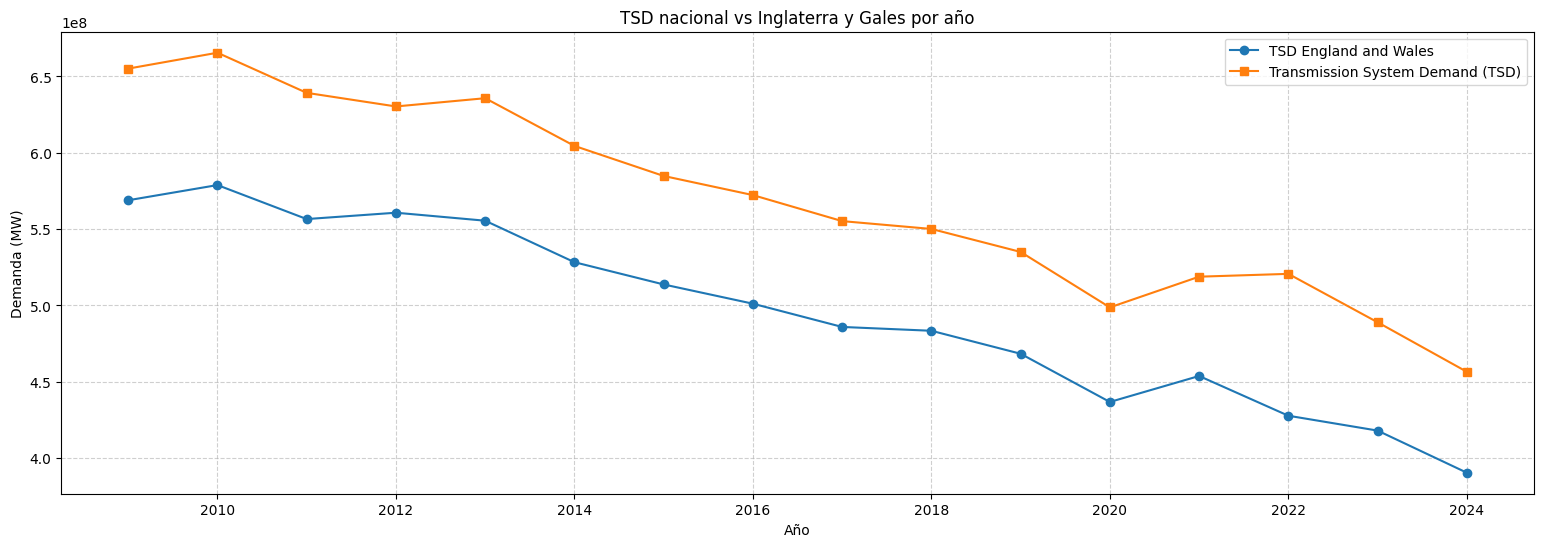

In [55]:
plt.figure(figsize=(19,6))
plt.plot(df_anual["year"], df_anual["england_wales_demand"], marker="o", label="TSD England and Wales")
plt.plot(df_anual["year"], df_anual["tsd"], marker="s", label="Transmission System Demand (TSD)")
plt.xlabel("Año")
plt.ylabel("Demanda (MW)")
plt.title("TSD nacional vs Inglaterra y Gales por año")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Observamos que la demanda de Gales e Inglaterra se comporta de la misma forma que la demanda total.

#### Gráfico de estacionalidad anual

In [56]:
def estacionalidad_anual(df, column, freq=12, title="Seasonal Plot"):

    df = df.copy()

    # Convertimos la columna 'month' en datetime si es necesario
    if "month" in df.columns:
        df["month"] = pd.to_datetime(df["month"], format="%Y-%m", errors="coerce")
        df = df.dropna(subset=["month"])
        df = df.set_index("month")
    else:
        raise ValueError("El DataFrame debe tener una columna 'month' con formato YYYY-MM.")

    # Creamos columnas auxiliares
    df["year"] = df.index.year
    df["season"] = df.index.month if freq == 12 else df.index.dayofyear

    # Filtramos la columna numérica
    df = df[[column, "year", "season"]].rename(columns={column: "value"})

    # Graficamos
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x="season", y="value", hue="year", data=df, palette="tab10", marker="o"
    )

    plt.xticks(range(1, 13), meses_ordenados)
    plt.title(title)
    plt.xlabel("Mes")
    plt.ylabel(column)
    plt.legend(title="Año", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

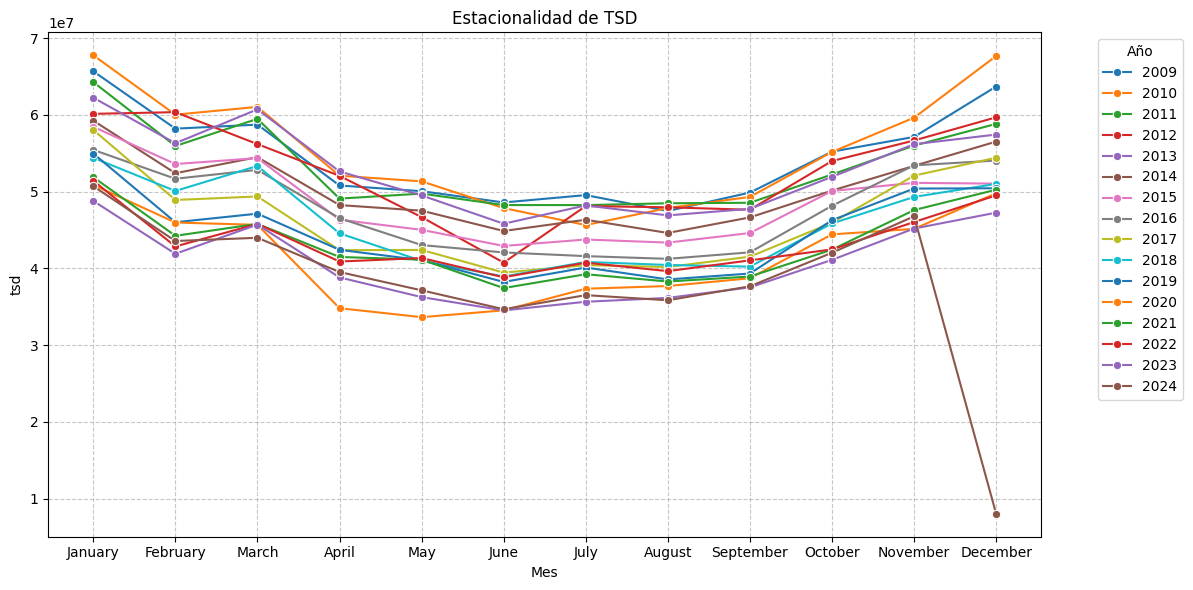

In [57]:
estacionalidad_anual(df_mensual, "tsd", freq=12, title="Estacionalidad de TSD")

Observamos que cada se repiten los mismos patrones, por lo que los datos presentan una estacionalidad anual, con periodo de 12.

#### Matriz de correlaciones

                           settlement_period        nd       tsd  \
settlement_period               1.000000e+00  0.420380  0.388920   
nd                              4.203803e-01  1.000000  0.990826   
tsd                             3.889204e-01  0.990826  1.000000   
england_wales_demand            4.234290e-01  0.998874  0.990236   
embedded_wind_generation        3.982183e-02 -0.157395 -0.148379   
embedded_wind_capacity          3.227115e-05 -0.444728 -0.441129   
embedded_solar_generation       6.725871e-02 -0.154035 -0.171060   
embedded_solar_capacity         2.054799e-05 -0.446728 -0.444570   
is_holiday                     -2.510674e-06 -0.066386 -0.068599   
year                            1.170073e-07 -0.449155 -0.438854   

                           england_wales_demand  embedded_wind_generation  \
settlement_period                      0.423429                  0.039822   
nd                                     0.998874                 -0.157395   
tsd                 

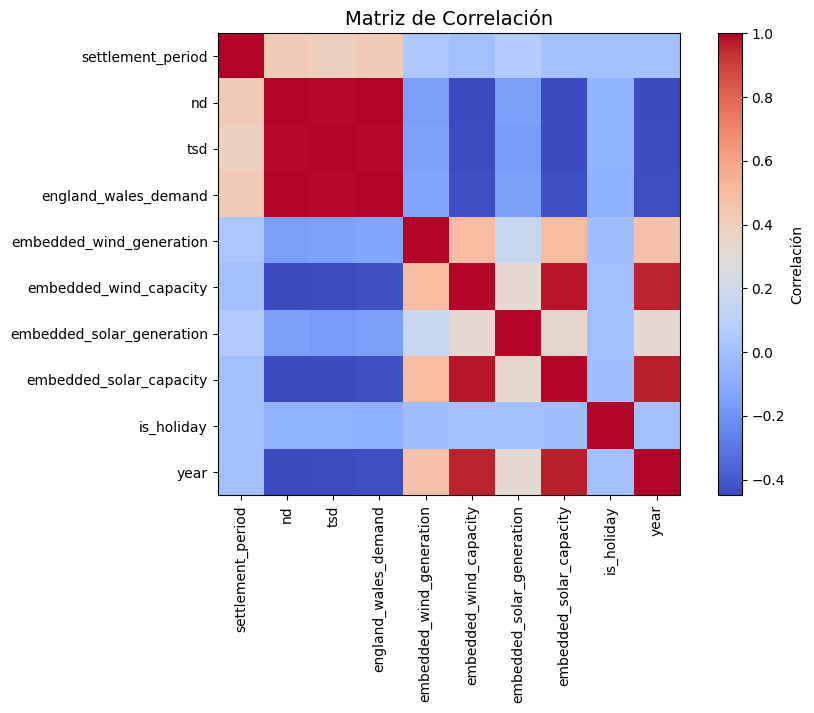

In [58]:
corr_matrix = df.corr(numeric_only=True)
print(corr_matrix)

plt.figure(figsize=(10, 6))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlación")
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title("Matriz de Correlación", fontsize=14)
plt.show()

Las variables de demanda ${nd}$, ${tsd}$ y ${england\_wales\_demand}$ están muy correladas, lo que tiene sentido ya que las tres variables tratan sobre demanda eléctrica.

Por su parte, lo están las variables ${embedded\_solar\_capacity}$ y ${embedded\_wind\_apacity}$.

Además, la variable ${is\_holiday}$ está ligeramente correlada negativamente, lo que indica que en los festivos la demanda tiende a ser menor.

#### Mapa de calor del consumo medio por mes y día de la semana

/tmp/ipython-input-73225918.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_diario.pivot_table(


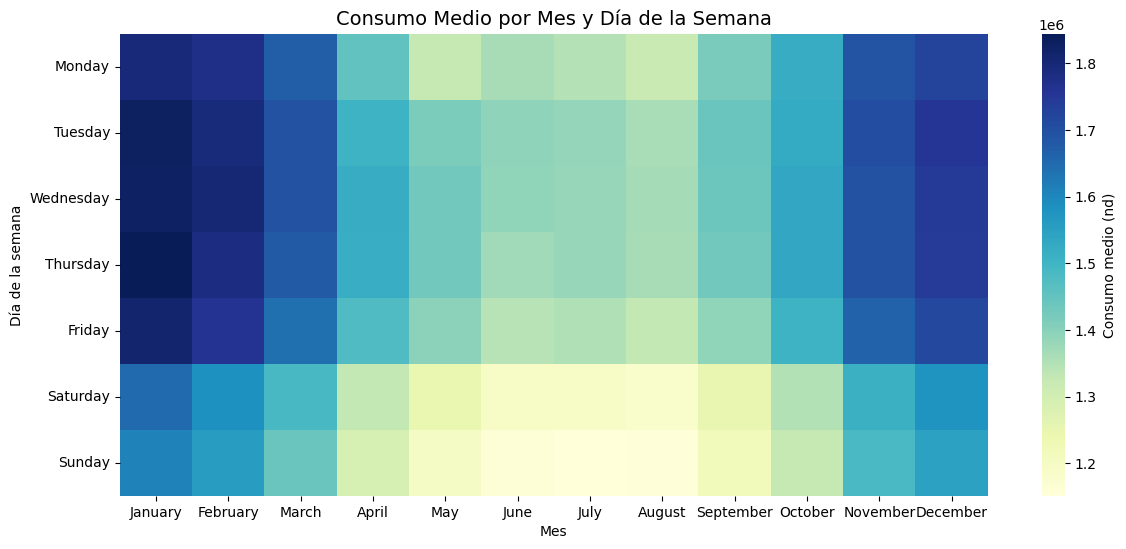

In [59]:
# Ordenamos los días para que no salgan en orden alfabético, sino cronológico (los meses ya están ordenados de antes)
dias_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Crearmos una tabla pivote con la media del consumo por mes y día de la semana
pivot = df_diario.pivot_table(
    index="day_of_week",
    columns="month",
    values="nd",
    aggfunc="mean"
)

# Reordenamos filas y columnas
pivot = pivot.reindex(index=dias_ordenados, columns=meses_ordenados)

# Dibujamos el mapa de calor
plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Consumo medio (nd)'})
plt.title("Consumo Medio por Mes y Día de la Semana", fontsize=14)
plt.xlabel("Mes")
plt.ylabel("Día de la semana")
plt.show()

Los días en que más se consume son de lunes a viernes (también lo fines de semana, pero en menor medida), especialmente los meses de enero a marzo y de noviembre a diciembre. El resto de meses hay un consumo notable de lunes a viernes. Los fines de semana de los meses de abril a octubre hay apenas consumo en comparación al resto de tiempo.

#### Mapa de calor del consumo medio por hora y día de la semana

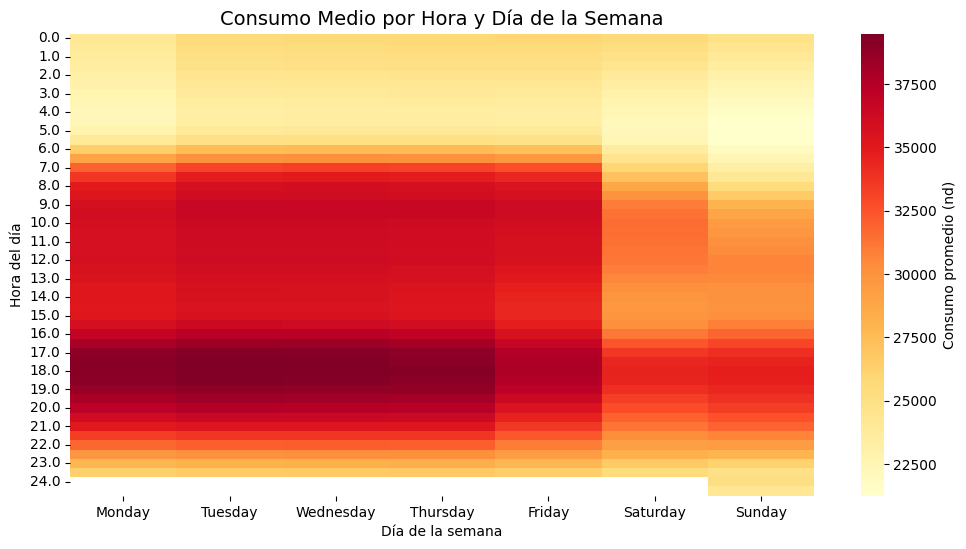

In [60]:
# Creamos un daaframe copia para no modificar el original
df1 = df.copy()

# Calcular la hora en formato decimal
df1["hour"] = ((df1["settlement_period"] - 1) * 0.5)

# Añadimos una columna con el nombre del día de la semana
df1["day_of_week"] = df1["settlement_date"].dt.day_name()

# Crear tabla pivote con la media del consumo por hora y día de la semana
pivot_hours = df1.pivot_table(
    index="hour",
    columns="day_of_week",
    values="nd",
    aggfunc="mean"
)

# Reordenar las columnas
pivot_hours = pivot_hours[dias_ordenados]

# Dibujamos el mapa de calor
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_hours, cmap="YlOrRd", cbar_kws={'label': 'Consumo promedio (nd)'}, annot=False)
plt.title("Consumo Medio por Hora y Día de la Semana", fontsize=14)
plt.xlabel("Día de la semana")
plt.ylabel("Hora del día")
plt.show()


Cuando más consumo se produce es entre las 7 de la mañana hasta las 10 de la noche de lunes a viernes, lo cual es lógico ya que son las horas del día en que la gente desarrolla su actividad. Durante la madrugada no hay apenas consumo. Por su parte, durante el fin de semana se aprecia consumo las horas de la tarde y las primeras horas de la mañana.

### 2.2 Visualización de los festivos

Estudiamos la proporción de festivos y no festivos.

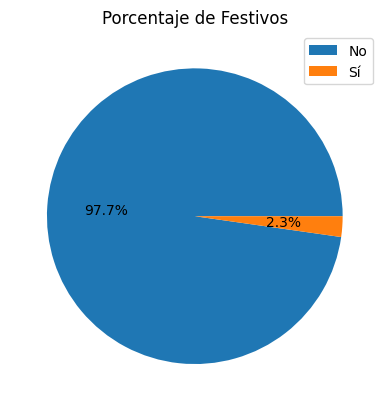

In [61]:
holidays_counts = df['is_holiday'].value_counts()

# Generamos etiquetas solo para la leyenda
labels = ['No' if val == 0 else 'Sí' for val in holidays_counts.index]

plt.figure()
plt.pie(holidays_counts, labels=[''] * len(holidays_counts), autopct='%1.1f%%')  # Sin texto en el gráfico
plt.title('Porcentaje de Festivos')
plt.legend(labels)
plt.show()

Podemos observar que la mayoría de los datos son de días no festivos.

Ahora, vamos a comparar la demanda eléctrica de los días festivos y los días regulares con un gráfico ${box}$ ${plot}$.

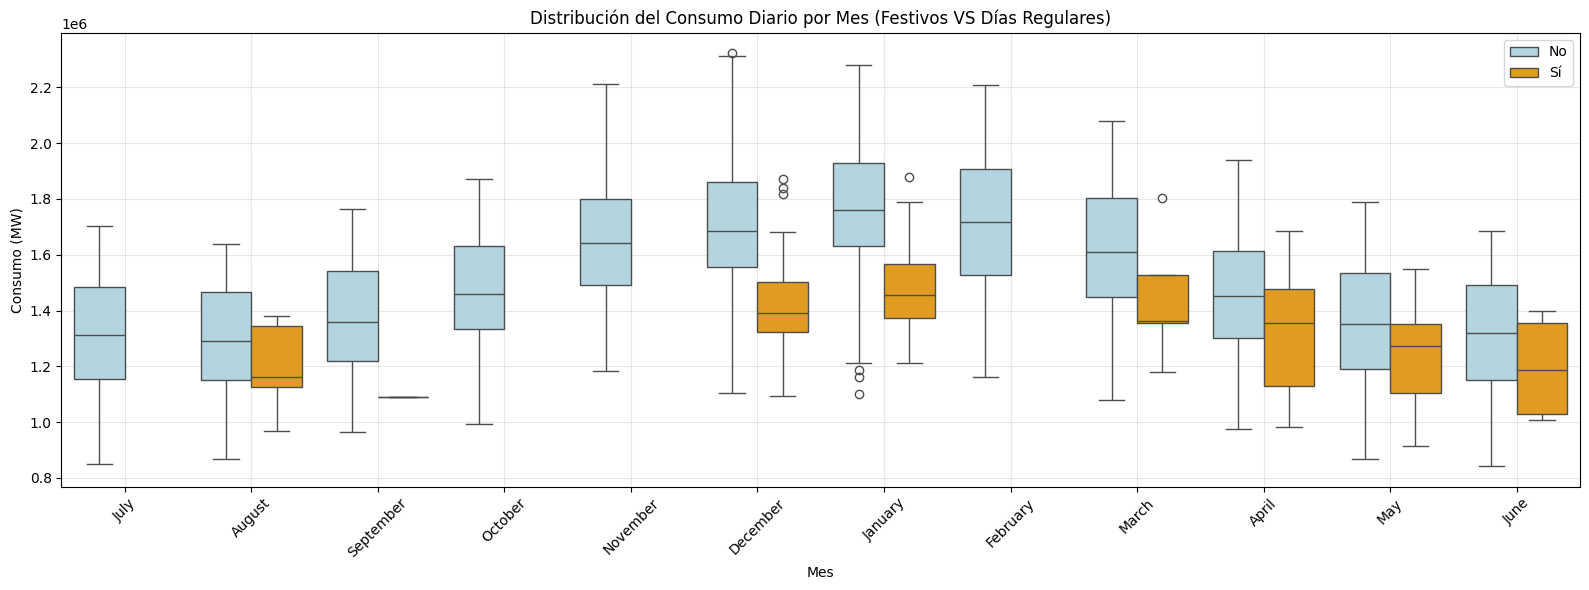

In [103]:
# Orden deseado empezando en junio
orden_meses = ["July", "August", "September", "October", "November", "December",
               "January", "February", "March", "April", "May", "June"]

plt.figure(figsize=(16, 6))
sns.boxplot(
    data=df_diario,
    x="month",
    y="nd",
    hue="festivo",
    palette={"No": "lightblue", "Sí": "orange"},
    hue_order=["No", "Sí"],
    order=orden_meses
)
plt.xticks(rotation=45)
plt.ylabel("Consumo (MW)")
plt.xlabel("Mes")
plt.title("Distribución del Consumo Diario por Mes (Festivos VS Días Regulares)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

El consumo general parece seguir una distribución normal.

Por su parte, los días festivos no siguen una distribución normal, habiendo incluso meses en lo que no se encuentran días festivos. Una cuestión cocherente sería el porqué los días festivos no sigen una distribución normal.

La respuesta podría ser que los festivos son mucho menos frecuentes que los días regulares. Entonces, al ser la muestra de un tamaño pequeño, se genera distribuciones más irregulares. Ocurre que en algunos meses se encuentran solamente 1 o 2 festivos, lo que hace que el ${box}$ ${plot}$ se vea deformado o con una sola línea. Todo ello impide que sigan una distribución normal.

Otra cuestión interesante sería por qué se da que el consumo sea menor en días festivos.

En casi todos los meses en que están, las cajas de los días festivos están desplazadas hacia abajo; es decir, la mediana y los cuartiles son menores. Esto puede deberse a que en los festivos la actividad industrial y comercial se reduce fuertemente (lo que hace que aumente en los días anteriores y posteriores). El consumo doméstico no compensa esa caída, lo que da como resultado una menor demanda total.

Además, este gráfico también permite ver una estacionalidad en los meses: en invierno (enero, febrero, diciembre), la demanda es más alta (debido a lacalefacción, la iluminación ...); mientras que en verano (junio–agosto), es más baja (en Reino Unido las temperaturas no son tan altas como para poner aires acondicionados).

Ahora, estudiamos el efecto de los días festivos en el consumo a lo largo de la semana en que se encuentre el día festivo. Para ello, vamos a comparar el consumo en el día festivo con el consumo medio de la semana en que se encuentre dicho día a través del porcentaje de diferencia relativa entre ambas cosas.

/tmp/ipython-input-971348646.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado["diferencia_relativa_%"] = ((resultado["nd"] - resultado["nd_promedio_semana"]) /


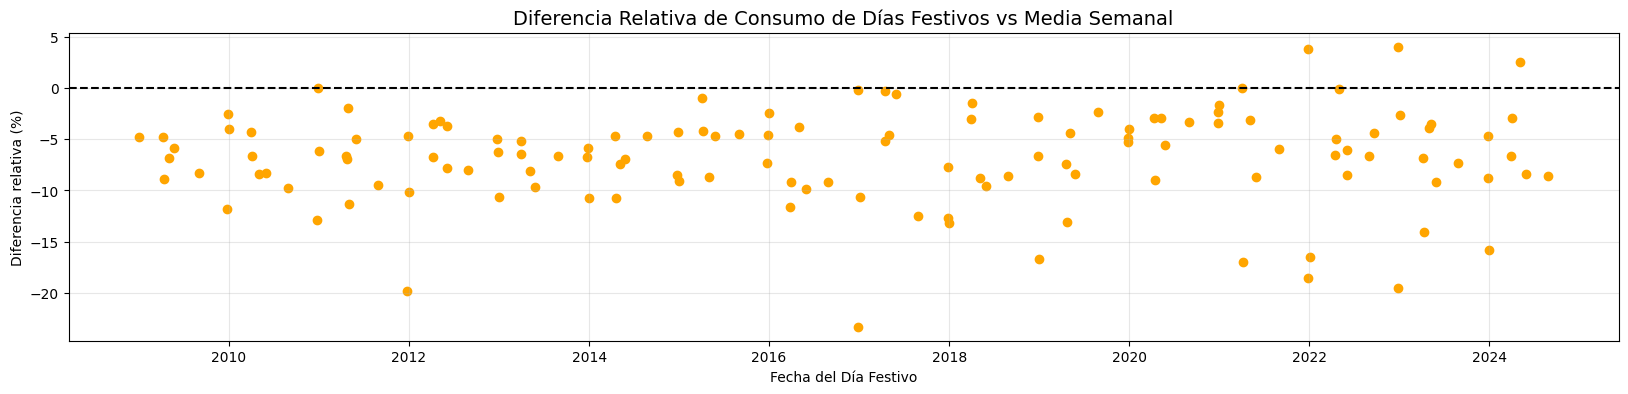

In [63]:
# Filtramos por los días festivos
df_festivos = df_diario[df_diario["is_holiday"] == 1].copy()

# Calculamos el consumo medio por semana y año
consumo_semanal = df_diario.groupby(["year", "week"])["nd"].mean().reset_index()
consumo_semanal = consumo_semanal.rename(columns={"nd": "nd_promedio_semana"})

# Unimos el consumo semanal con los días festivos y nos quedamos con las columnas necesarias
df_festivos = pd.merge(df_festivos, consumo_semanal, on=["year", "week"], how="left")
resultado = df_festivos[["settlement_date", "nd", "nd_promedio_semana"]]

# Añadir columna con porcentaje de diferencia
resultado["diferencia_relativa_%"] = ((resultado["nd"] - resultado["nd_promedio_semana"]) /
                                      resultado["nd_promedio_semana"]) * 100
# Graficamos
plt.figure(figsize=(20, 4))
plt.scatter(resultado["settlement_date"], resultado["diferencia_relativa_%"], color="orange")
plt.axhline(0, color="black", linestyle="--")
plt.title("Diferencia Relativa de Consumo de Días Festivos vs Media Semanal", fontsize=14)
plt.xlabel("Fecha del Día Festivo")
plt.ylabel("Diferencia relativa (%)")
plt.grid(alpha=0.3)
plt.show()

Observamos claramente que el consumo de un día festivo tiende a ser menor que el promedio de la semana en casi todos los casos.

Además, vamos a observar el efecto de días festivos en la demanda dos días antes y dos días después.

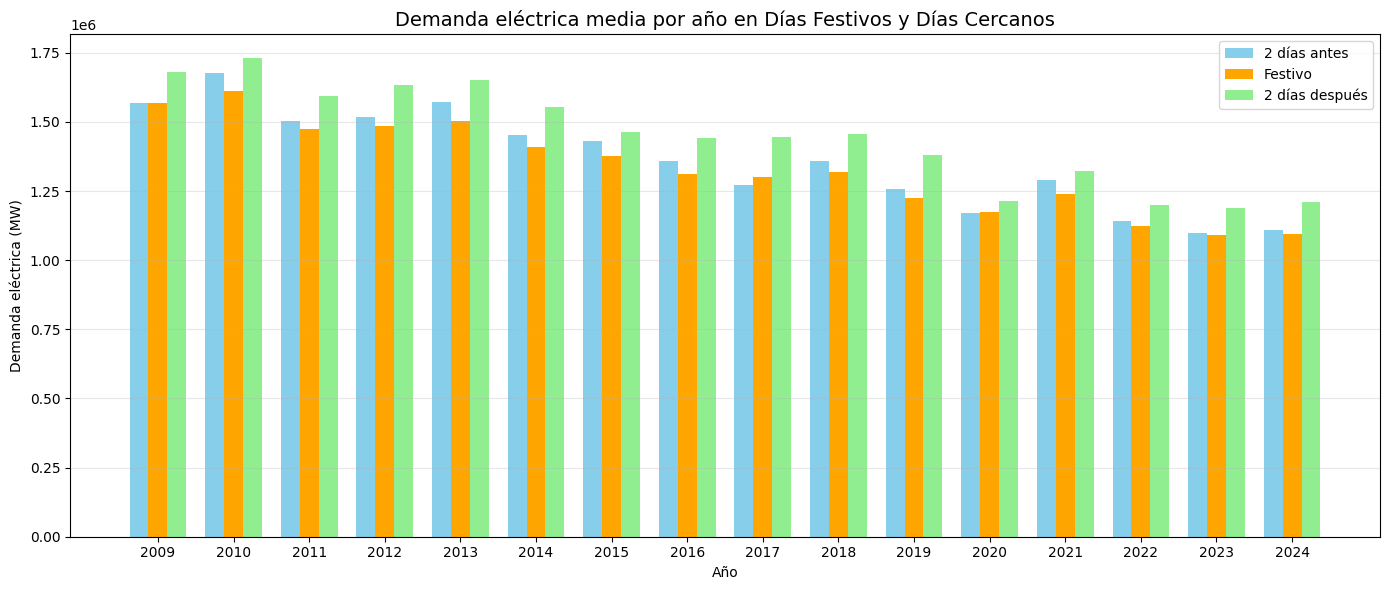

In [64]:
df_diario_indexed = df_diario.set_index("settlement_date").sort_index()

# Calculamos las medias
resultados = []

for año, grupo in df_festivos.groupby(df_festivos["settlement_date"].dt.year):
    consumos_antes, consumos_festivo, consumos_despues = [], [], []

    for fecha in grupo["settlement_date"]:
        # 2 días antes
        dias_antes = [fecha - pd.Timedelta(days=i) for i in [1, 2]]
        valores_antes = [df_diario_indexed["nd"].get(d) for d in dias_antes if d in df_diario_indexed.index]
        if valores_antes:
            consumos_antes.append(np.mean(valores_antes))

        # Día festivo
        if fecha in df_diario_indexed.index:
            consumos_festivo.append(df_diario_indexed.loc[fecha, "nd"])

        # 2 días después
        dias_despues = [fecha + pd.Timedelta(days=i) for i in [1, 2]]
        valores_despues = [df_diario_indexed["nd"].get(d) for d in dias_despues if d in df_diario_indexed.index]
        if valores_despues:
            consumos_despues.append(np.mean(valores_despues))

    resultados.append({
        "Año": año,
        "Media 2 días antes": np.mean(consumos_antes) if consumos_antes else np.nan,
        "Media festivos": np.mean(consumos_festivo) if consumos_festivo else np.nan,
        "Media 2 días después": np.mean(consumos_despues) if consumos_despues else np.nan
    })

df_resumen = pd.DataFrame(resultados).dropna().sort_values("Año")

# Graficamos
plt.figure(figsize=(14,6))
años = df_resumen["Año"].astype(int)
x = np.arange(len(años))
width = 0.25

plt.bar(x - width, df_resumen["Media 2 días antes"], width=width, label="2 días antes", color="skyblue")
plt.bar(x, df_resumen["Media festivos"], width=width, label="Festivo", color="orange")
plt.bar(x + width, df_resumen["Media 2 días después"], width=width, label="2 días después", color="lightgreen")

plt.xticks(x, años)
plt.xlabel("Año")
plt.ylabel("Demanda eléctrica (MW)")
plt.title("Demanda eléctrica media por año en Días Festivos y Días Cercanos", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

En el diagrama de barras podemos ver que se repite el mismo patrón: durante el día festivo se consumo menos que antes y después y en los días posteriores se consume más que en los anteriores. Por tanto, podemos concluir que, tras un día festivo, sube el promedio de consumo eléctrico.

Además, una vez más podemos ver que la tendencia que se sigue es que la demanda eléctrica baje con los años.

Así pues, podríamos preguntarnos por qué esa subida tras un festivo. Podría deberse a diferentes factores, como:

* La reanudación de la actividad económica: tras un festivo, llos sectores económicos vuelven a operar a plena capacidad, lo que genera un pico de consumo.
* Un efecto de compensación: las empresas y hogares tienden a posponer actividades durante los días festivos, entonces este trabajo se acumula y se recupera rápidamente en los días siguientes
* El efecto calendario: a menudo los festivos caen en lunes o viernes, de modo que el “2 días después” puede coincidir con laborales.

### 2.3 Estudio de las Energías Renovables

#### Comparación entre la energía eólica generada contra la máxima capacidad

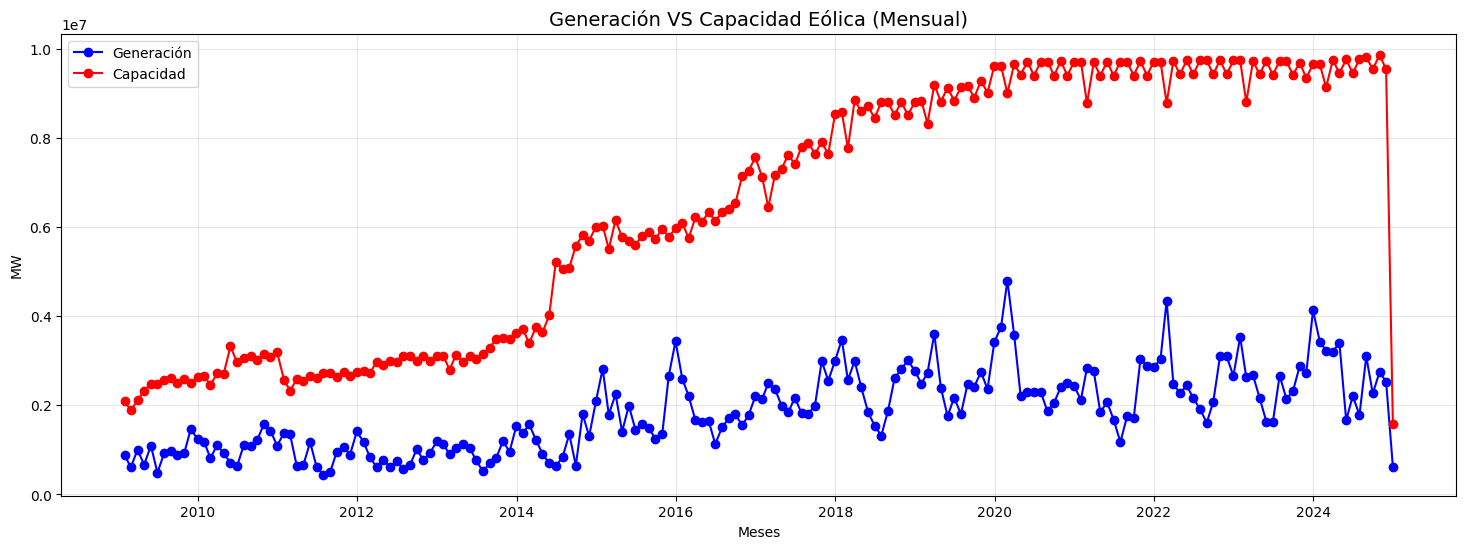

In [65]:
plt.figure(figsize=(18, 6))

# Línea de generación real
plt.plot(df_mensual["settlement_date"], df_mensual["embedded_wind_generation"],
         label="Generación", color="blue", marker="o")

# Línea de capacidad
plt.plot(df_mensual["settlement_date"], df_mensual["embedded_wind_capacity"],
         label="Capacidad", color="red", marker="o")

plt.title("Generación VS Capacidad Eólica (Mensual)", fontsize=14)
plt.xlabel("Meses")
plt.ylabel("MW")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Observamos que la curva roja (capacidad máxima para generar energía eólica) crece desde el 2009 hasta el 2020, lo que implica que en esos años se crearon numerosos parques eólicos. En los siguientes años no se crearon, pues la curva roja se mantiene constante. En lo que respecta a la curva azul (generación de energía eólica) es mucho más variable, porque depende de las condiciones del viento, aunque presenta picos en los meses de invierno y otoño y valles en verano. Se repiten los mismos patrones todos los años.

Además, apreciamos que la creación de parques eólicos no supone un incremento sustancial en la generación de energía eléctrica, de ahí que el error entre la capacidad máxima y la energía realmente generada crezca conforme aumentan la capacidad y la generación.

#### Comparación entre la energía solar generada contra la máxima capacidad

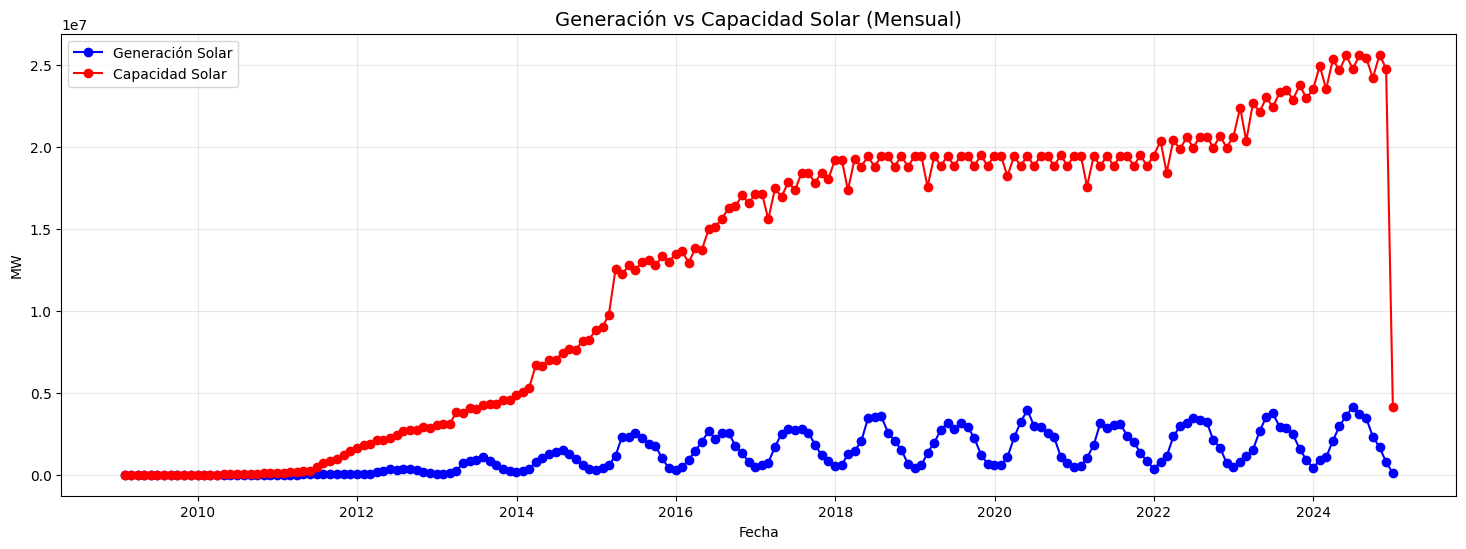

In [66]:
plt.figure(figsize=(18, 6))

# Línea de generación real
plt.plot(df_mensual["settlement_date"], df_mensual["embedded_solar_generation"],
         label="Generación Solar", color="blue", marker="o")

# Línea de capacidad
plt.plot(df_mensual["settlement_date"], df_mensual["embedded_solar_capacity"],
         label="Capacidad Solar", color="red", marker="o")

plt.title("Generación vs Capacidad Solar (Mensual)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("MW")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Lo relacionado con la energía solar se empezó a contabilizar y tener repercusión a mediados de 2011. Notamos que se ha estado inviertiendo en energía solar hasta 2018 y se continuó desde 2021 hasta 2024, pues la curva roja (capacidad máxima para generar energía solar) aumenta en esos años. En cuanto a la curva azul (generación de energía solar), observamos que la generación de energía solar se mantiene constante a lo largo de los años, mostrando picos en verano y valles en el resto de estaciones. Se repite el mismo patrón cada año.

Además, se aprecia que la inversión en energía solar no supone un incremento en la generación de energía eléctrica, de ahí que el error entre la capacidad máxima y la energía realmente generada se dispare.

#### Comparación semanal de la energía eólica/solar generada con la máxima capacidad

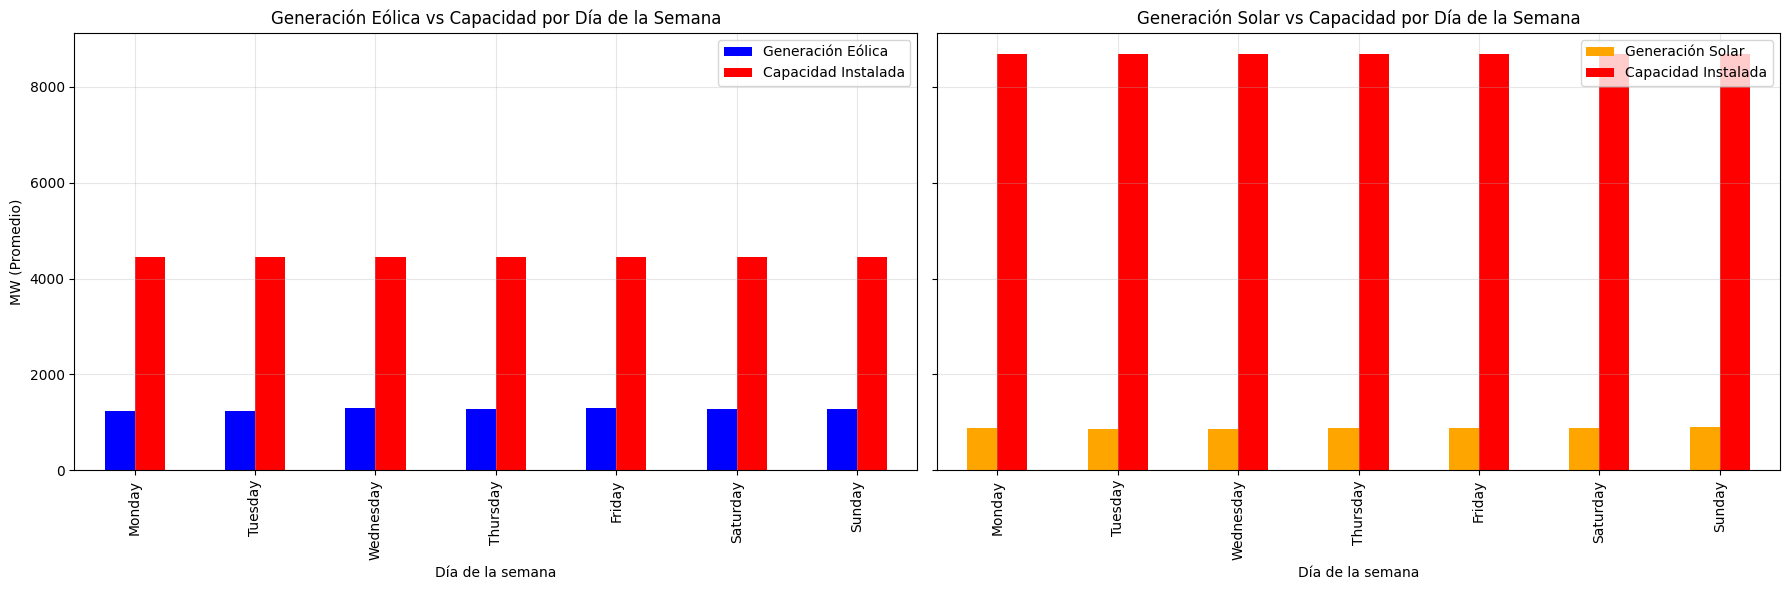

In [67]:
# Agrupación eólica
df_semana_wind = df.groupby("day_of_week")[["embedded_wind_generation", "embedded_wind_capacity"]].mean()
df_semana_wind = df_semana_wind.reindex(dias_ordenados)

# Agrupación solar
df_semana_solar = df.groupby("day_of_week")[["embedded_solar_generation", "embedded_solar_capacity"]].mean()
df_semana_solar = df_semana_solar.reindex(dias_ordenados)

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Eólica
df_semana_wind.plot(kind="bar", ax=axes[0], color=["blue", "red"])
axes[0].set_title("Generación Eólica vs Capacidad por Día de la Semana", fontsize=12)
axes[0].set_xlabel("Día de la semana")
axes[0].set_ylabel("MW (Promedio)")
axes[0].grid(alpha=0.3)
axes[0].legend(["Generación Eólica", "Capacidad Instalada"])

# Solar
df_semana_solar.plot(kind="bar", ax=axes[1], color=["orange", "red"])
axes[1].set_title("Generación Solar vs Capacidad por Día de la Semana", fontsize=12)
axes[1].set_xlabel("Día de la semana")
axes[1].grid(alpha=0.3)
axes[1].legend(["Generación Solar", "Capacidad Instalada"])

# Graficamos
plt.tight_layout()
plt.show()

No hay un cambio significativo entre diferentes días de la semana, ni para la generación de energía ni para la capacidad máxima.
Observamos que la capacidad máxima queda bastante por encima de la real generada, destacando esta diferencia para la energía solar.

#### Comparación mensual de la energía eólica/solar generada con la máxima capacidad

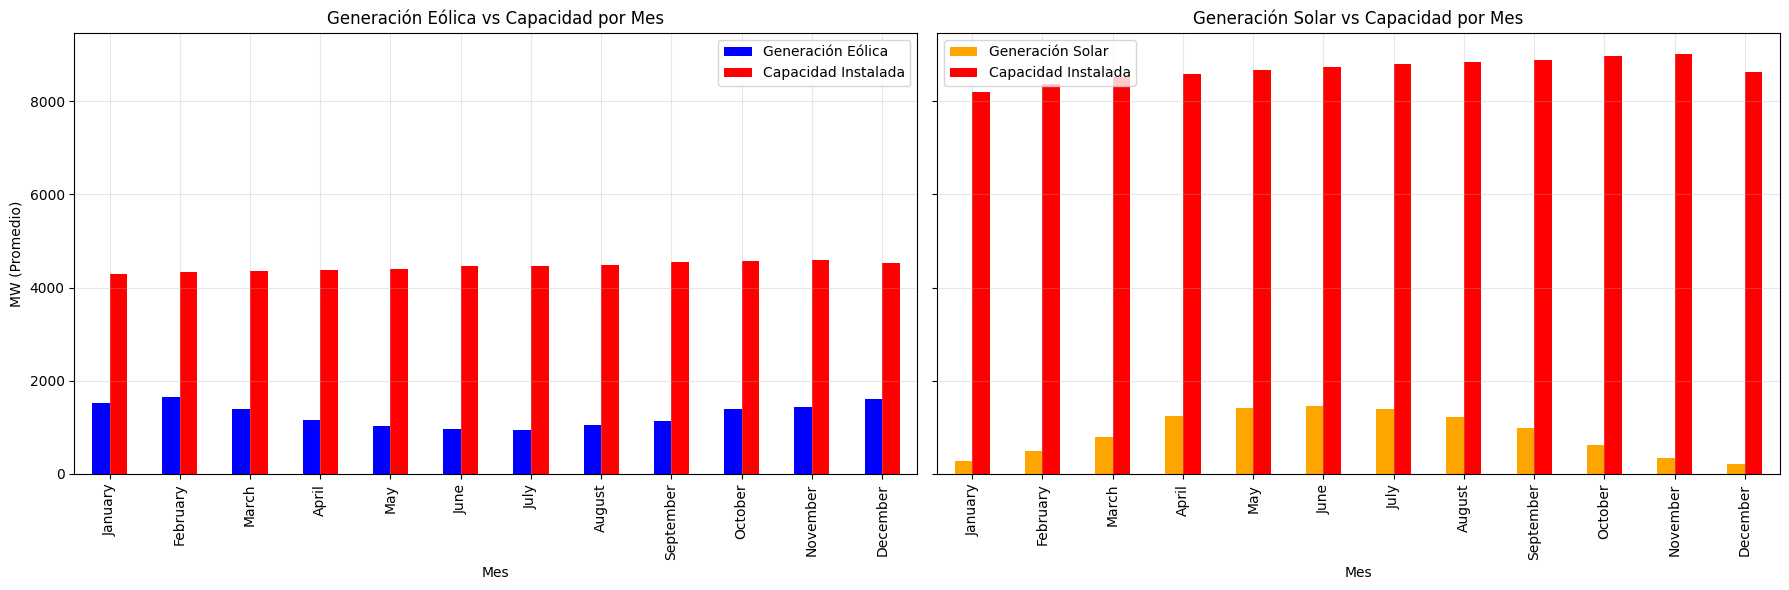

In [68]:
# Agrupación eólica
df_mes_wind = df.groupby("month")[["embedded_wind_generation", "embedded_wind_capacity"]].mean()

# Agrupación solar
df_mes_solar = df.groupby("month")[["embedded_solar_generation", "embedded_solar_capacity"]].mean()

# Reordenamos los meses en orden natural
df_mes_wind = df_mes_wind.reindex(meses_ordenados)
df_mes_solar = df_mes_solar.reindex(meses_ordenados)

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Eólica
df_mes_wind.plot(kind="bar", ax=axes[0], color=["blue", "red"])
axes[0].set_title("Generación Eólica vs Capacidad por Mes", fontsize=12)
axes[0].set_xlabel("Mes")
axes[0].set_ylabel("MW (Promedio)")
axes[0].grid(alpha=0.3)
axes[0].legend(["Generación Eólica", "Capacidad Instalada"])

# Solar
df_mes_solar.plot(kind="bar", ax=axes[1], color=["orange", "red"])
axes[1].set_title("Generación Solar vs Capacidad por Mes", fontsize=12)
axes[1].set_xlabel("Mes")
axes[1].grid(alpha=0.3)
axes[1].legend(["Generación Solar", "Capacidad Instalada"])

# Graficamos
plt.tight_layout()
plt.show()

Observamos que la capacidad máxima de generación de energía se mantiene constante a lo largo de los meses, mientras que la generación real sí que varía en función de los meses.

#### Comparación mensual en la generación real de energía por ambas fuentes de energía

<Figure size 1800x600 with 0 Axes>

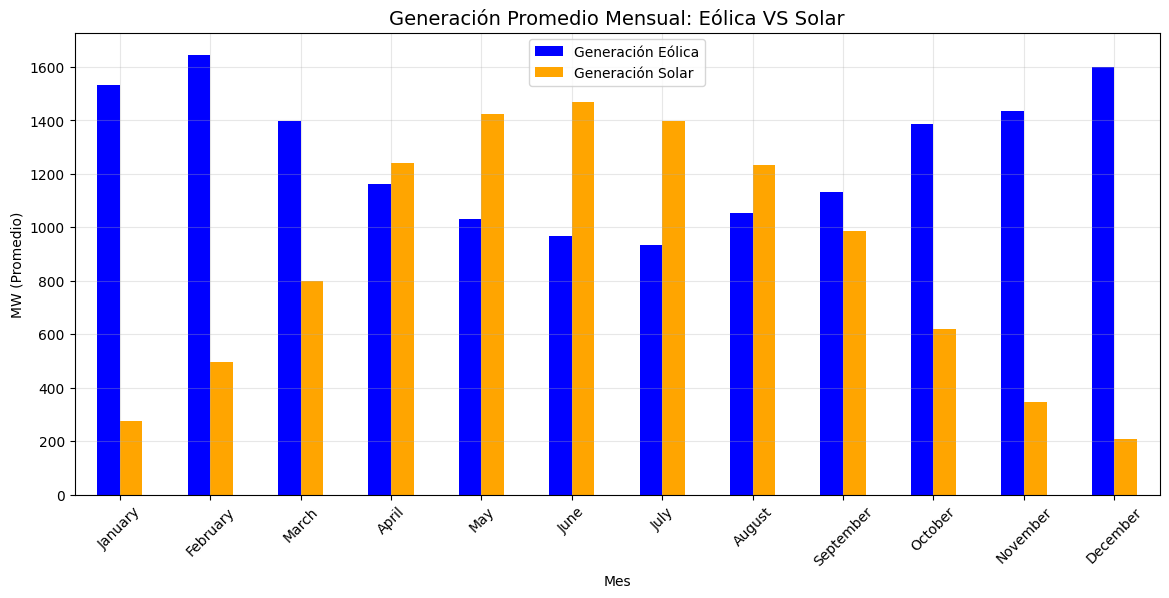

In [69]:
plt.figure(figsize=(18, 6))

# Agrupar por mes y calcular el promedio de generación (solo)
df_mes_generation = df.groupby("month")[["embedded_wind_generation", "embedded_solar_generation"]].mean()

# Reordenamos los meses en orden natural
df_mes_generation = df_mes_generation.reindex(meses_ordenados)

# Graficamos
df_mes_generation.plot(kind="bar", figsize=(14, 6), color=["blue", "orange"])
plt.title("Generación Promedio Mensual: Eólica VS Solar", fontsize=14)
plt.xlabel("Mes")
plt.ylabel("MW (Promedio)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(["Generación Eólica", "Generación Solar"])
plt.show()

Observamos como, en general, se genera más energía eólica que solar en cada mes, exceptuando de abril a agosto (desde final de primavera hasta verano). Los mínimos en energía eólico son considerablemente mayores a los de la energía solar, y los máximos en energía solar se quedan en el top 4 en lo que respecta a los máximos en energía eólica.

#### Comparación de la demanda nacional anual contra las energías eólica y solar generadas

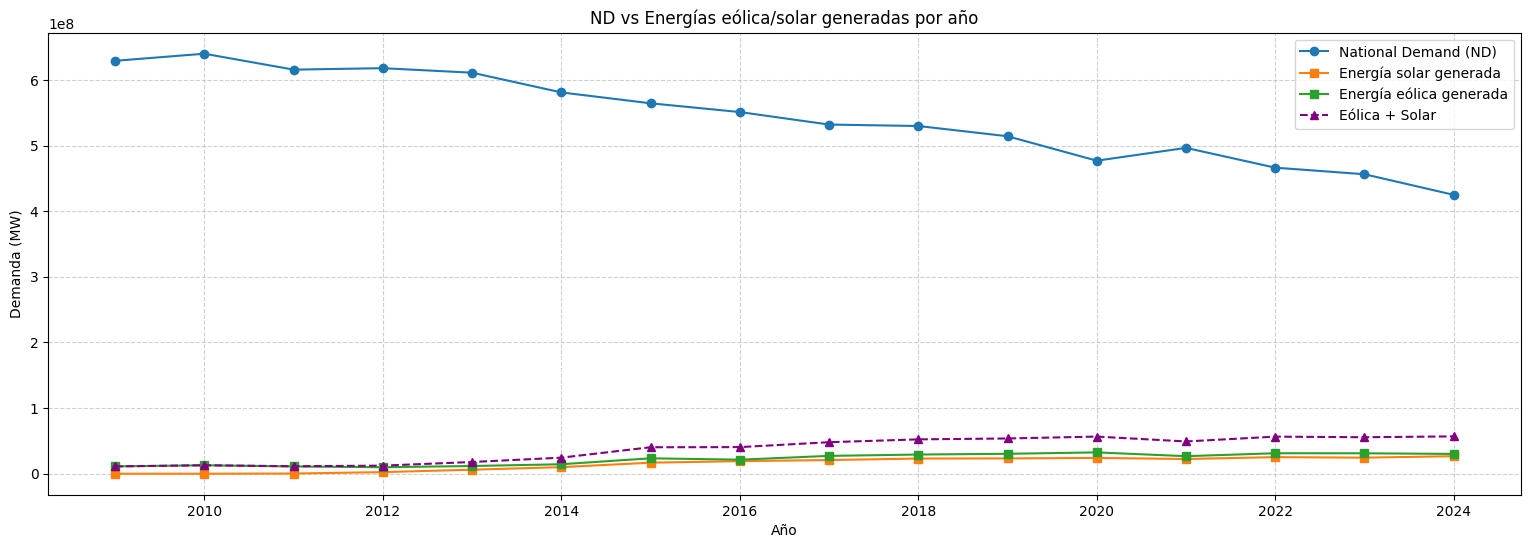

In [70]:
plt.figure(figsize=(19,6))
plt.plot(df_anual["year"], df_anual["nd"], marker="o", label="National Demand (ND)")
plt.plot(df_anual["year"], df_anual["embedded_solar_generation"], marker="s", label="Energía solar generada")
plt.plot(df_anual["year"], df_anual["embedded_wind_generation"], marker="s", label="Energía eólica generada")
plt.plot(df_anual["year"], df_anual["Eolica_Solar"], marker="^", linestyle="--", color="purple", label="Eólica + Solar")
plt.xlabel("Año")
plt.ylabel("Demanda (MW)")
plt.title("ND vs Energías eólica/solar generadas por año")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Observamos que la energía que se genera tanto eólica como solar ni se acerca a la demanda nacional. De la misma forma, la suma ambas energías generadas queda muy lejos de la demanda nacional.

Esto tiene sentido en Uk ya que aún depende de centrales térmicas, nucleares y gas para cubrir el resto de la demanda. De hecho, como hemos visto anteriormete, la capacidad instalada nunca se da al máximo, pues depende de factores externos no controlables.

Así, resulta interesante preguntarse cuánto debería aumentar la generación de energías renovables para que puedieran sustentar la demanda nacional.

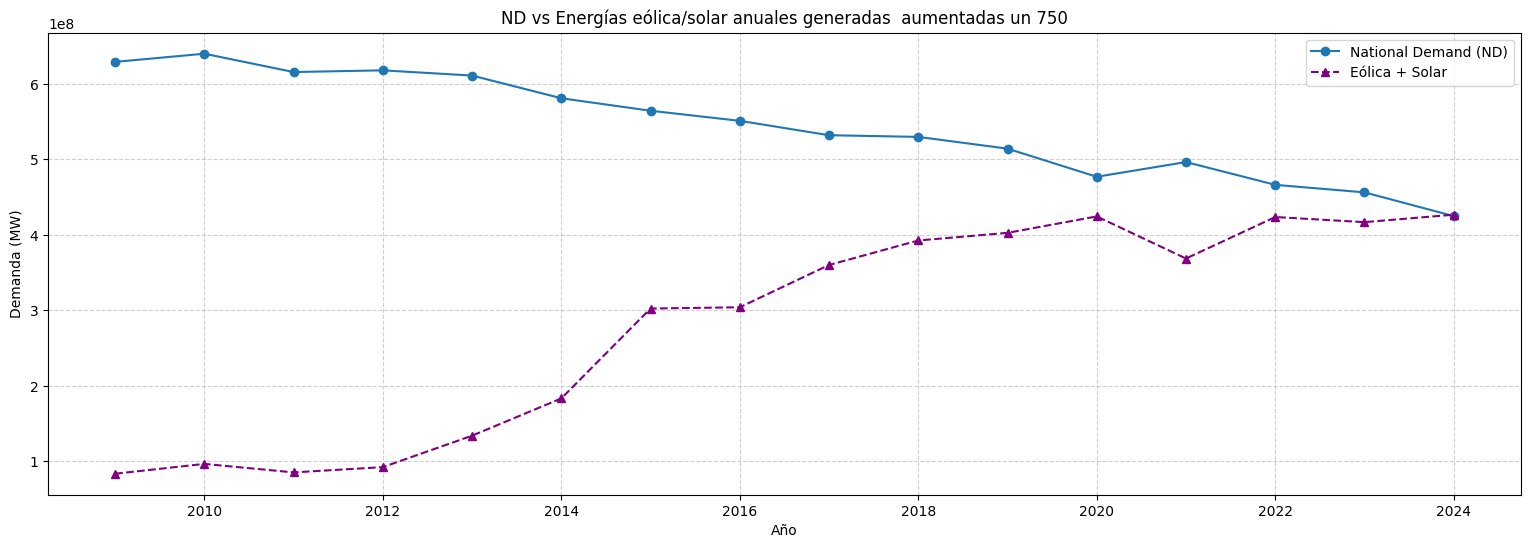

In [71]:
plt.figure(figsize=(19,6))
plt.plot(df_anual["year"], df_anual["nd"], marker="o", label="National Demand (ND)")
plt.plot(df_anual["year"], 7.5*df_anual["Eolica_Solar"], marker="^", linestyle="--", color="purple", label="Eólica + Solar")
plt.xlabel("Año")
plt.ylabel("Demanda (MW)")
plt.title("ND vs Energías eólica/solar anuales generadas  aumentadas un 750")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Como mínimo, sería necesario que la generación de energía por fuentes renovables aumentase un 750% para que convergieran la demanda nacional y la generación eléctrica media fuentes renovables.

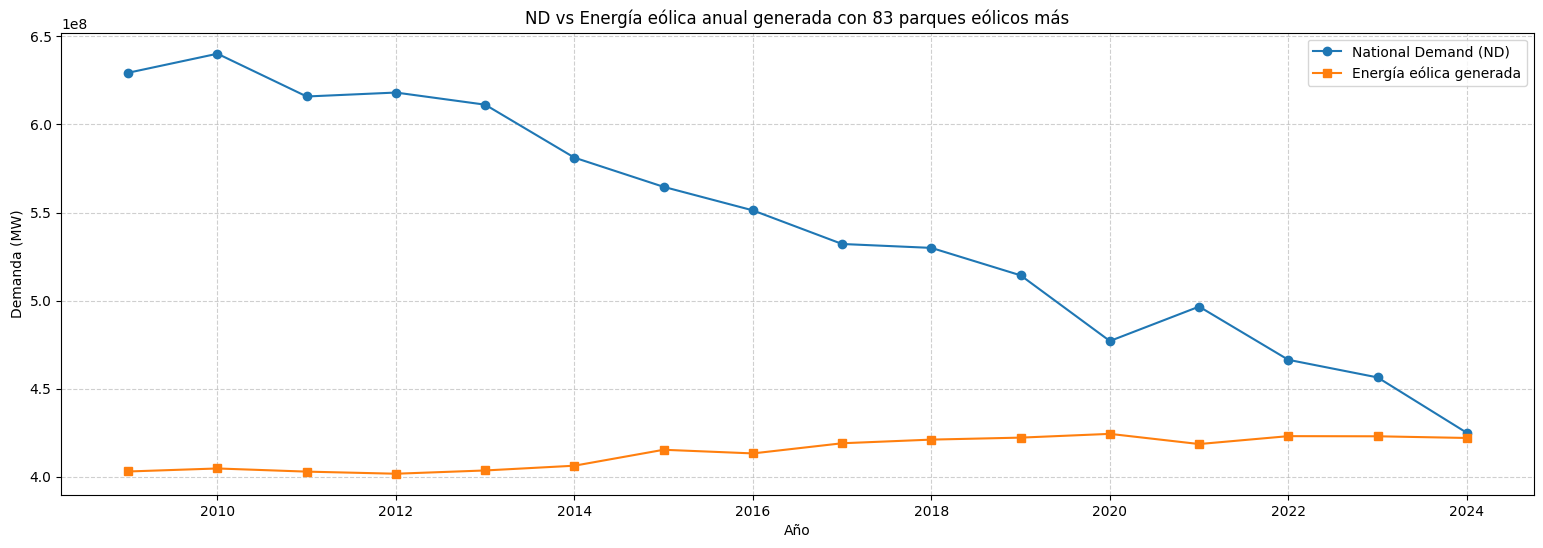

In [72]:
plt.figure(figsize=(19,6))
plt.plot(df_anual["year"], df_anual["nd"], marker="o", label="National Demand (ND)")
plt.plot(df_anual["year"], 83*4721640+df_anual["embedded_wind_generation"], marker="s", label="Energía eólica generada")
plt.xlabel("Año")
plt.ylabel("Demanda (MW)")
plt.title("ND vs Energía eólica anual generada con 83 parques eólicos más")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Además, teniendo en cuenta que un parque eólico en UK puede llegar a generar de media unos 539 MW (tomando como referencia el de Whitelee), harían falta 83 parques eólicos más para que convergieran la demanda nacional y la generación de energía eólica.

In [73]:
df["wind_percent"] = (df["embedded_wind_capacity"] / df["nd"]) * 100
df["solar_percent"] = (df["embedded_solar_capacity"] / df["nd"]) * 100

print("El porcentaje que representa la capacidad eólica es del:", df["wind_percent"].mean())
print("El porcentaje que representa la capacidad solar es del:", df["solar_percent"].mean())

El porcentaje que representa la capacidad eólica es del: 15.949932254889072
El porcentaje que representa la capacidad solar es del: 31.929161446844052


/tmp/ipython-input-2313949995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["wind_percent"] = (df["embedded_wind_capacity"] / df["nd"]) * 100
/tmp/ipython-input-2313949995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["solar_percent"] = (df["embedded_solar_capacity"] / df["nd"]) * 100


Ahora bien, dentro de toda la capacidad de producción eléctrica del país, ¿qué porcentaje representa la capacidad solar y la eólica ?¿Fue la eólica en 2022 realmente del 23% como dice Iberdrola? Pues podríamos decir que sí, prácticamente, y que la energía solar representa un 16%.

In [74]:
df_anual["wind_percent"] = (df_anual["embedded_wind_capacity"] / df_anual["nd"]) * 100
df_anual["solar_percent"] = (df_anual["embedded_solar_capacity"] / df_anual["nd"]) * 100

tabla_capacidades = df_anual.groupby("year")[["wind_percent", "solar_percent"]].mean().reset_index()
tabla_capacidades.columns = ["Año", "Capacidad eólica (%)", "Capacidad solar (%)"]
print(tabla_capacidades.to_string(index=False))

 Año  Capacidad eólica (%)  Capacidad solar (%)
2009              4.573389             0.000000
2010              5.537580             0.088776
2011              5.121240             1.317253
2012              5.788617             4.755019
2013              6.335199             7.972033
2014              9.804153            14.742759
2015             12.377961            26.120639
2016             14.128217            33.235289
2017             17.007130            39.958236
2018             19.473989            43.056891
2019             21.045216            44.542580
2020             23.992321            48.165225
2021             23.026750            46.145225
2022             24.576036            51.896960
2023             25.062550            59.797175
2024             25.249582            65.525755


De hecho, observamos como la capacidad solar es mucho mayor a la capacidad eolica, el inconveniente es que la energía solar generada es muchísimo menor a la capacidad. Lo mismo sucede en el caso de la energía eólica: la capacidad es muy mayor que la energía generada

De ahí que sea inviable sustentar la demanda nacional con estas dos energías renoavables, y tampoco parece viable a largo plazo.

## 3. Modelos de predicción

### 3.1 Árbol de decisión

In [75]:
df3 = df[["settlement_date",
          "settlement_period",
          "embedded_wind_generation",
          "embedded_wind_capacity",
          "embedded_solar_generation",
          "embedded_solar_capacity",
          "is_holiday",
          "tsd"]]

df3["ds"] = df3["settlement_date"] + pd.to_timedelta((df3["settlement_period"]-1)*30, unit='m')

/tmp/ipython-input-1523001062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["ds"] = df3["settlement_date"] + pd.to_timedelta((df3["settlement_period"]-1)*30, unit='m')


In [76]:
X = df3[["settlement_date",
          "ds",
          "embedded_wind_generation",
          "embedded_wind_capacity",
          "embedded_solar_generation",
          "embedded_solar_capacity",
          "is_holiday"]]

Y = df3["tsd"]

In [77]:
# División del dataset: train hasta 2020 incluido, test desde 2021
X_train = X.loc[df["settlement_date"] <= "2021-12-31"]
y_train = Y.loc[df["settlement_date"] <= "2021-12-31"]

X_test = X.loc[df["settlement_date"] >= "2022-01-01"]
y_test = Y.loc[df["settlement_date"] >= "2022-01-01"]

# Eliminamos las columnas innecesarias
X_train = X_train.drop(columns=['settlement_date'])
X_test = X_test.drop(columns=['settlement_date'])

In [78]:
# Entrenamos el modelo
model1 = DecisionTreeRegressor(max_depth=3, random_state=42)
model1.fit(X_train.drop(columns=["ds"]), y_train)

# Predicción en Train
y_train_pred = model1.predict(X_train.drop(columns=["ds"]))

# Predicción en Test
y_test_pred = model1.predict(X_test.drop(columns=["ds"]))

Limitamos el árbol a 3 ramas para que sea fácil de interpretar y porque un aumento de ramas en este caso no supone una mejora considerable en el rendimiento del modelo.

#### Métricas de error

In [79]:
def EVAL_METRICS_FUNC(y_true, y_pred, name=""):
    def MAPE(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Metric evaluation results for {name}:")
    print(f"  MAE: {metrics.mean_absolute_error(y_true, y_pred)}")
    print(f"  MAPE: {MAPE(y_true, y_pred)}")
    print(f"  MSE:  {mse:.2f}")
    print(f"  R2:   {r2:.3f}")

In [80]:
EVAL_METRICS_FUNC(y_train, y_train_pred, name="Train")

Metric evaluation results for Train:
  MAE: 5228.844961833263
  MAPE: 16.289447626069528
  MSE:  43880086.64
  R2:   0.254


In [81]:
EVAL_METRICS_FUNC(y_test, y_test_pred, name="Test")

Metric evaluation results for Test:
  MAE: 4547.607800146228
  MAPE: 16.818996814931413
  MSE:  31602510.20
  R2:   0.003


Si ponemos hasta 10 ramas en el árbol, el modelo tiene un MAPE de 13%, que no es una mejorar sustancial en comparación a la pérdida de interpretabilidad que se produce.

#### Gráfico del árbol

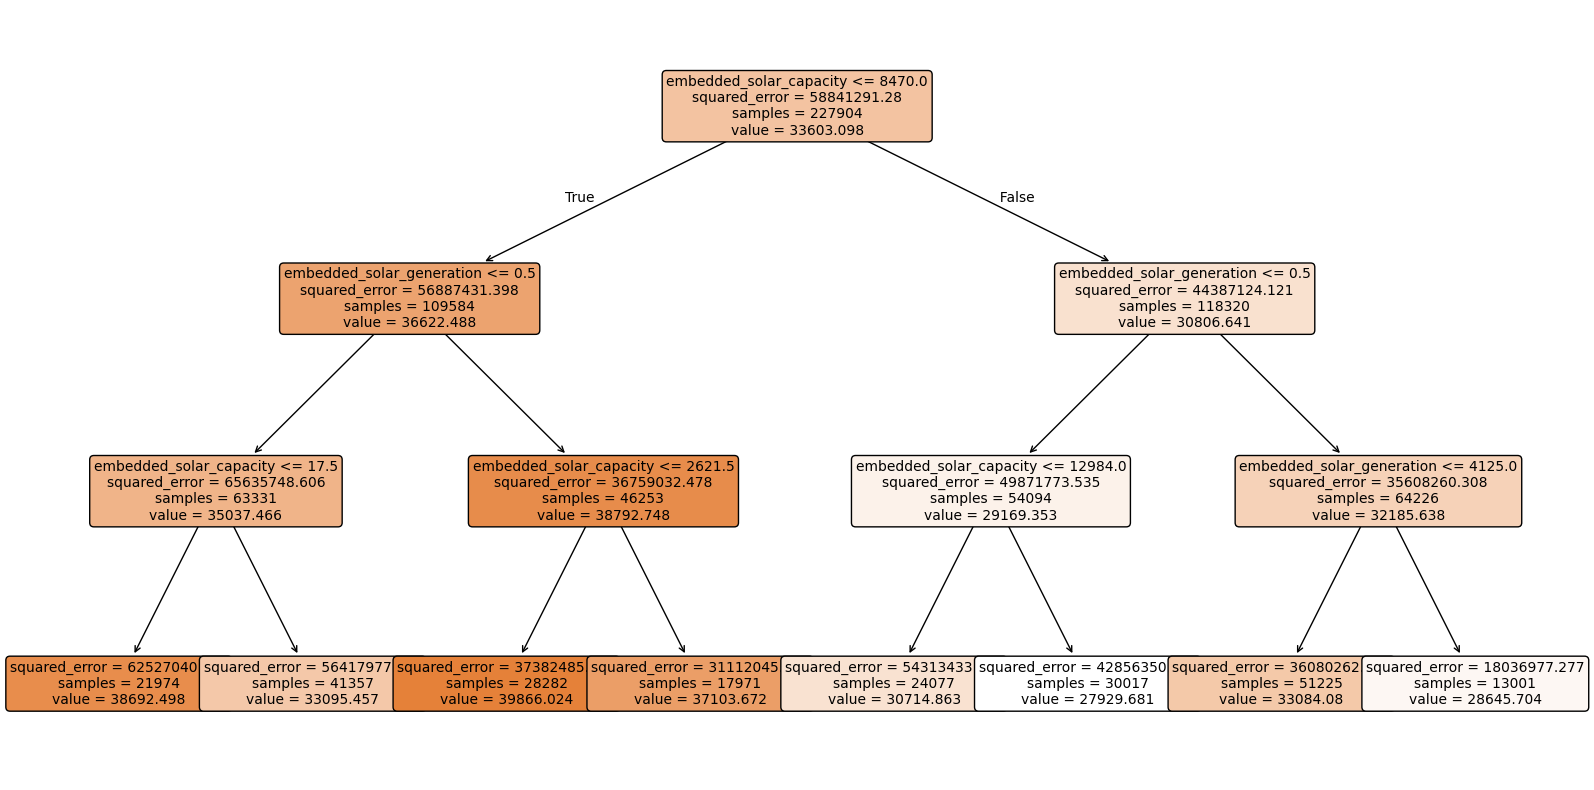

In [82]:
plt.figure(figsize=(20,10))
plot_tree(
    model1,
    feature_names=X_train.drop(columns=["ds"]).columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

**Nodo raíz**

* Divide el árbol a partir de la variable *embedded_solar_capacity*, con la condición <= que 8470; es decir, el primer corte que realiza el árbol es si la capacidad para generar energía solar es mayor o igual que 8470 MW. Además, en *value* podemos ver la media de *tsd* en ese grupo.


**Ramas**

* True: divide la rama en función de la variable *embedded_solar_generation*, cortando cuando el valor es menor o igual que 0,5.
* False: también divide la rama en función de la variable *embedded_solar_generation*, cortando cuando el valor es menor o igual que 0,5.

**Ramas siguientes**
* True-True: divide la rama en función de la variable *embedded_solar_capacity*, cortando cuando el valor es menor o igual que 17,5.
* True-False: divide la rama en función de la variable *embedded_solar_capacity*, cortando cuando el valor es menor o igual que 2621,5.
* False-True: divide la rama en función de la variable *embedded_solar_capacity*, cortando cuando el valor es menor o igual que 12984.
* False-False: divide la rama en función de la variable *embedded_solar_generation*, cortando cuando el valor es menor o igual que 4125.

**Hojas** (nodos finales, abajo)**

* Podemos ver la métrica de error MSE para cada hoja, la cantidad de datos que llegan a cada hoja y el value muestra la media de *tsd* en cada hoja.

#### Gráfico de Shap Values

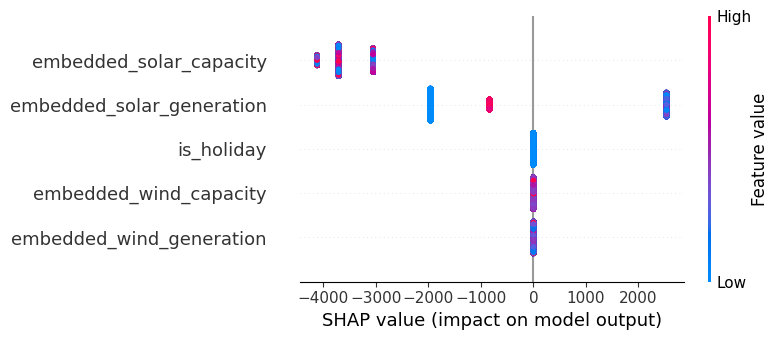

In [83]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test.drop(columns=["ds"]))
shap.summary_plot(shap_values, X_test.drop(columns=["ds"]))

Las variables más importantes son *embedded_solar_capacity* y *embedded_solar_generation*. Cuando hay mucha capacidad o generación solar, la predicción del modelo disminuye, y cuando hay poca energía solar, la predicción aumenta. Por tanto, la energía solar está inversamente correlacionada con la demanda eléctrica: si hay más energía solar disponible, la red necesita menos demanda.

En la variable *is_holiday*, los puntos están centrados cerca de 0, con una ligera tendencia negativa, lo que indica que en los días festivos el modelo predice una menor demanda eléctrica.

Por su parte, las variables *embedded_wind_capacity* y *embedded_wind_generation* presentan un impacto menor, con valores SHAP agrupados en torno a 0. Aunque el modelo no les da tanta importancia, los valores altos en generación eólica tienden a reducir ligeramente la predicción de demanda.

### 3.2 Prophet

In [84]:
df4 = df[["settlement_date",
          "ds",
          "embedded_wind_generation",
          "embedded_wind_capacity",
          "embedded_solar_generation",
          "embedded_solar_capacity",
          "tsd"]]

train = df4.loc[df["settlement_date"] <= "2021-12-31"]
test = df4.loc[df["settlement_date"] >= "2022-01-01"]

Prophet necesita que la variable fecha tenga el nombre ${ds}$ y la variable objetivo ${y}$.

In [85]:
# Renombrar columna objetivo
train = train.rename(columns={"tsd": "y"})
test = test.rename(columns={"tsd": "y"})

# Eliminar columnas innecesarias
train = train.drop(columns=['settlement_date'])
test = test.drop(columns=['settlement_date'])

Hacemos una lista por festivos pero solo por fecha, ignoramos los periodos ya que entonces nuestro ordenador no tiene la suficiente memoria RAM.

In [86]:
# Tomar solo los días festivos (una fila por día)
holidays_df = df[df['is_holiday'] == 1].copy()
holidays_df['ds'] = holidays_df['settlement_date']  # solo la fecha, ignorar periodos
holidays_df = holidays_df.drop_duplicates(subset='ds').reset_index(drop=True)
holidays_df['holiday'] = ['Festivo ' + str(i+1) for i in range(len(holidays_df))]
df_holidays = holidays_df[['ds','holiday']]

Elegimos un modelo Prophet con todos sus parámetros por defecto y le añadimos la lista de festivos.

In [87]:
model2 = Prophet(holidays=df_holidays)

# Train the model
model2.fit(train)

# Generate 21 months of future data
future = model2.make_future_dataframe(periods=len(test), freq="30min")

# Forecasting
forecast = model2.predict(future)
train[["yhat", "yhat_lower", "yhat_upper"]] = (
    forecast[["yhat", "yhat_lower", "yhat_upper"]].iloc[:len(train)].values
)
test.loc[:, ["yhat", "yhat_lower", "yhat_upper"]] = (
    forecast[["yhat", "yhat_lower", "yhat_upper"]].iloc[-len(test):].values
)

/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hmghe1g/7bdn4u0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hmghe1g/t1cfmsgq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61757', 'data', 'file=/tmp/tmp_hmghe1g/7bdn4u0v.json', 'init=/tmp/tmp_hmghe1g/t1cfmsgq.json', 'output', 'file=/tmp/tmp_hmghe1g/prophet_modelxy26w2vw/prophet_model-20251012174353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:53 - cmdstanpy - 

#### Gráfica de las predicciones

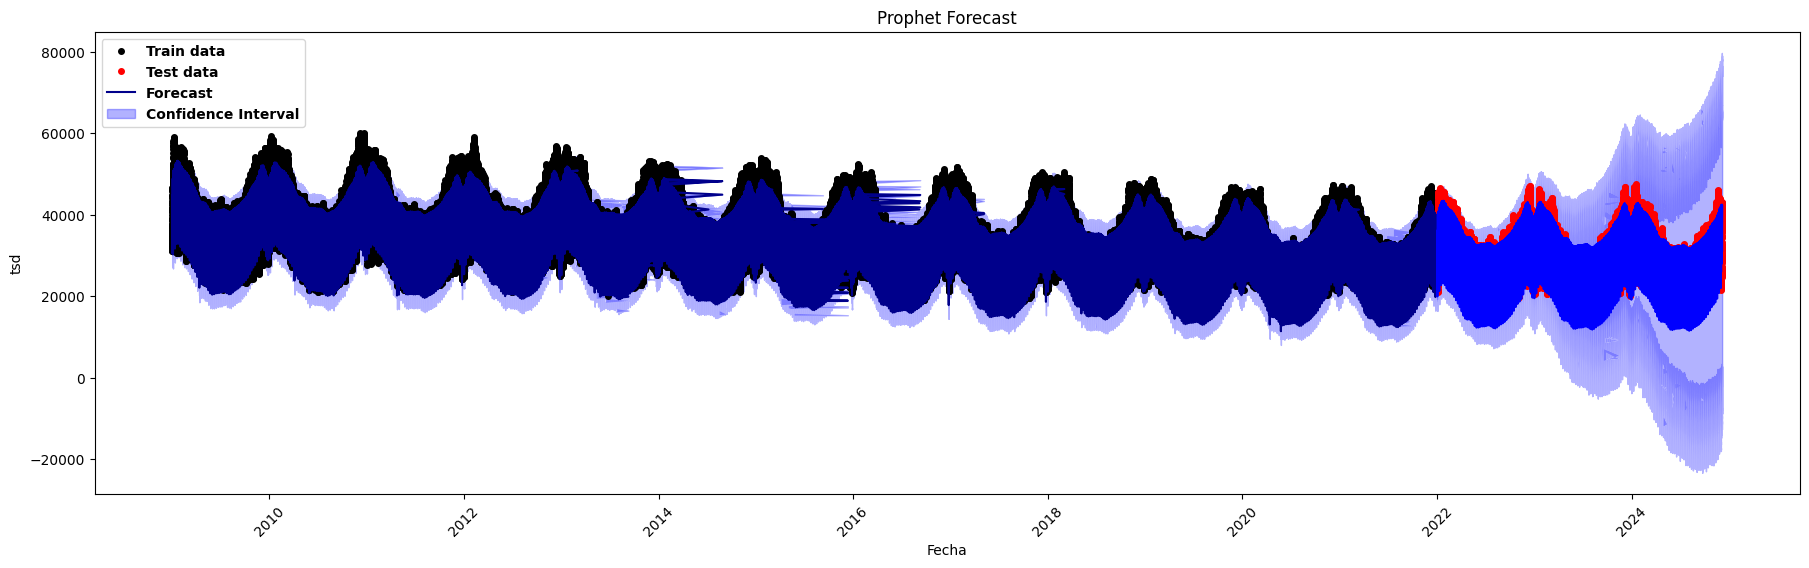

In [88]:
fig, ax = plt.subplots(figsize=(22, 6))

ax.plot(train["ds"], train["y"], "o", label="Train data", color="black", markersize=4)
ax.plot(test["ds"], test["y"], "o", label="Test data", color="red", markersize=4)

ax.plot(train["ds"], train["yhat"], label="Forecast", color="darkblue")
ax.plot(test["ds"], test["yhat"], color="blue")
ax.fill_between(
    train["ds"], train["yhat_lower"], train["yhat_upper"], color="blue", alpha=0.3
)
ax.fill_between(
    test["ds"],
    test["yhat_lower"],
    test["yhat_upper"],
    color="blue",
    alpha=0.3,
    label="Confidence Interval",
)

legend = plt.legend()
for text in legend.get_texts():
    text.set_fontweight('bold')
for text in legend.get_texts():
    text.set_fontweight('bold')
plt.title("Prophet Forecast", color="black")
plt.xlabel("Fecha")
plt.ylabel("tsd")
plt.xticks(rotation=45)

plt.show()

Podemos observar como las predicciones se encuentran dentro de los intervalos de confianza y tienden a ser menores menores que los datos reales, por lo que el modelo tiende a predecir menor demanda de la que realmente se consume. Además, podemos notar que los intervalos de confianza crecen cada vez más con el tiempo, por lo que el modelo con el tiempo se siente más inseguro.

#### Métricas de error

In [89]:
y_true = train["y"].values
y_pred = train["yhat"].values
EVAL_METRICS_FUNC(y_true, y_pred, name="Train")

Metric evaluation results for Train:
  MAE: 6180.799322352519
  MAPE: 19.97677659247861
  MSE:  58195104.71
  R2:   0.011


In [90]:
y_true = test["y"].values
y_pred = test["yhat"].values
EVAL_METRICS_FUNC(y_true, y_pred, name="Test")

Metric evaluation results for Test:
  MAE: 2659.935072663147
  MAPE: 9.995673590794492
  MSE:  11067997.10
  R2:   0.651


#### Componentes del modelo

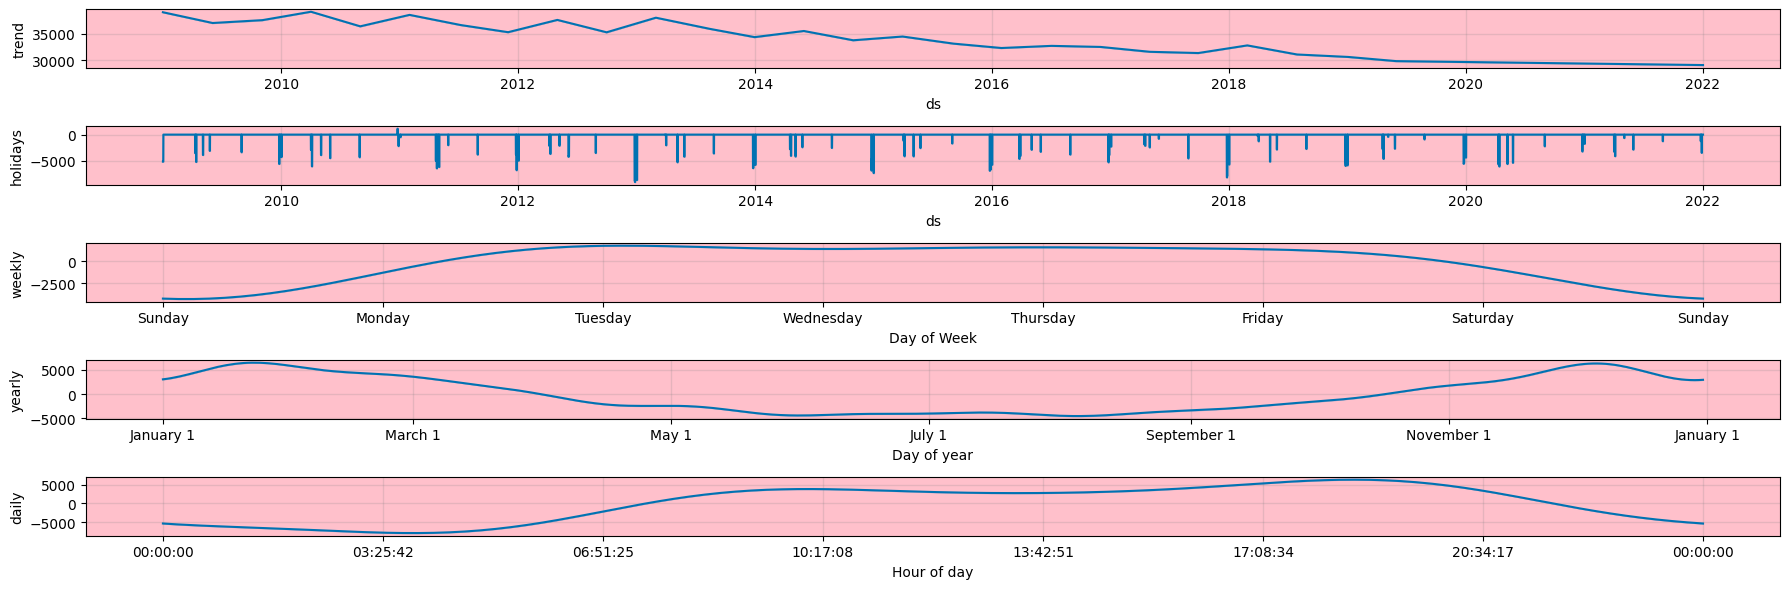

In [91]:
fig = model2.plot_components(forecast.head(len(train)), figsize=(18, 6))

for ax in fig.axes:
    ax.set_facecolor("pink")
    ax.title.set_color("black")
    ax.xaxis.label.set_color("black")
    ax.yaxis.label.set_color("black")
    ax.tick_params(axis="x", colors="black")
    ax.tick_params(axis="y", colors="black")

plt.show()

* Tendencia: se observa como la demanda eléctrica tiende a disminuir con los años.
* Festivos: en los días festivos la demanda disminuye.
* Estacionalidad semanal: se aprecia como la demanda se mantiene constante durante los días laborales y como tiende a disminuir en los fines de semana.
* Estacionalidad anual: durante los meses de invierno la demanda aumenta, mientras que durante el verano tiende a disminuir.
* Estacionalidad diaria: se mantiene constante durante las horas laborales y disminuye durante la noche.

Podemos apreciar que el análisis de estas componentes se corresponde con la visualización de datos realizada, por lo que parece que el modelo ha aprendido con cierta exactitud como se comportan los datos.

#### Componentes de la predicción

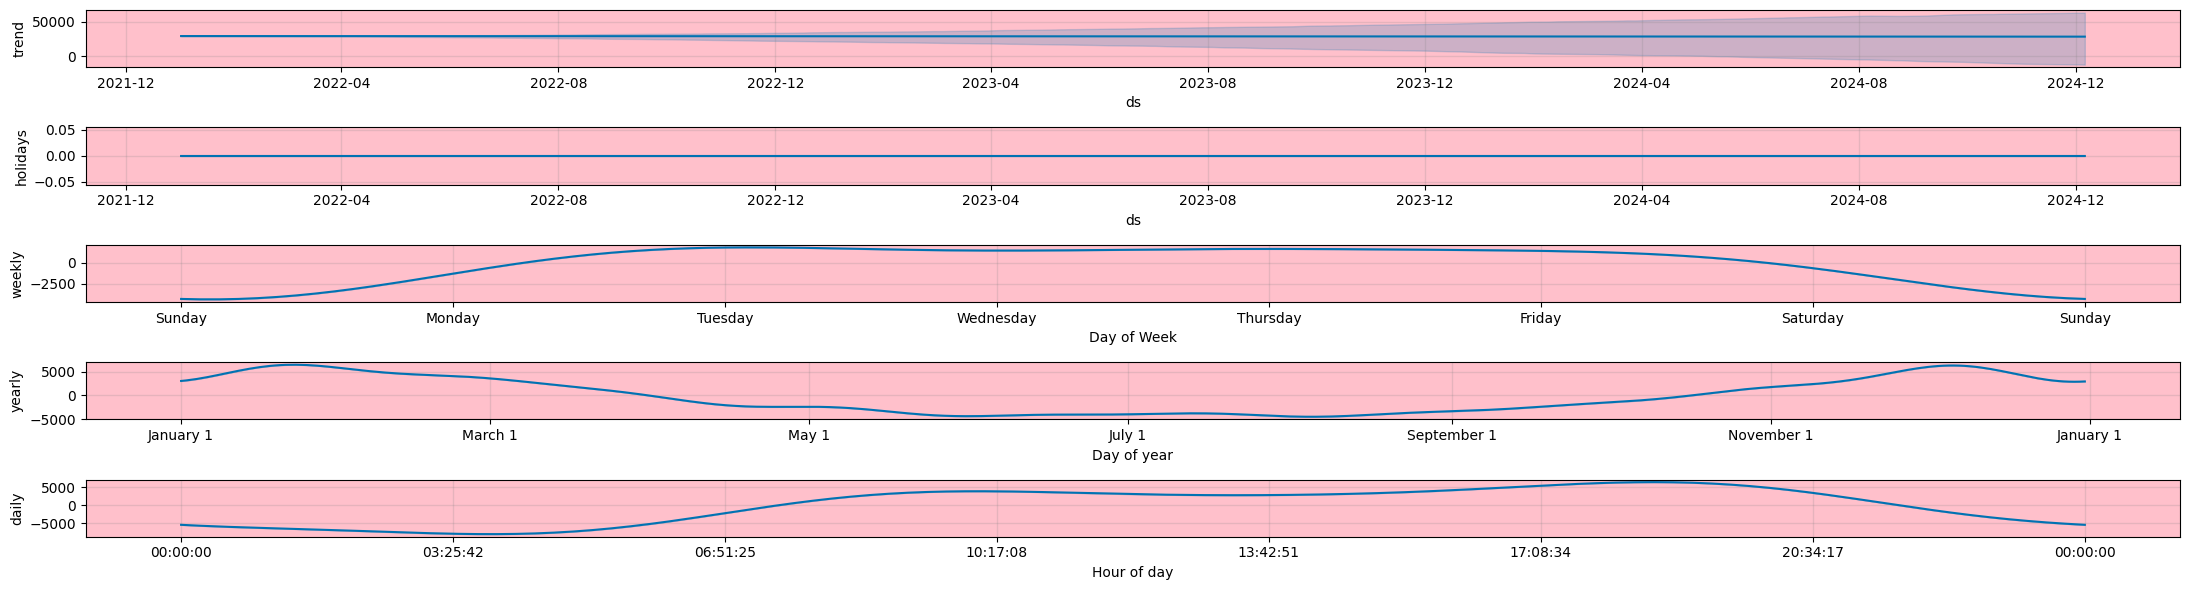

In [92]:
fig = model2.plot_components(forecast.tail(len(test)), figsize=(22, 6))


for ax in fig.axes:
    ax.set_facecolor("pink")
    ax.title.set_color("black")
    ax.xaxis.label.set_color("black")
    ax.yaxis.label.set_color("black")
    ax.tick_params(axis="x", colors="black")
    ax.tick_params(axis="y", colors="black")

plt.show()

* Tendencia: la demanda disminuye ligeramente durante los años, por lo que el modelo ha sabido captar la tendencia de los datos.
* Festivos: es una línea plana, por lo que los festivos no han aportado demasiado al modelo.
* Estacionalidad semanal, anual y diaria: se comportan tal como en las componentes del modelo, por lo que el modelo ha aprendido correctamente los diferentes tipos de estacionalidades del modelo.

### 3.3 XG BOOST

In [93]:
df5 = df[["settlement_date",
          "ds",
          "embedded_wind_generation",
          "embedded_wind_capacity",
          "embedded_solar_generation",
          "embedded_solar_capacity",
          "tsd"]]

In [94]:
def Augmented_Dickey_fuller_test_func(serie, column_name):
  print(f"Resultados de la prueba de Dickey-Fuller para la columna:",{column_name})
  dftest = adfuller(serie, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusión: ===>")
    print("Rechazar la hipótesis nula")
    print("Los datos son estacionarios")
  else:
    print("Conclusión: ===>")
    print("No se puede rechazar la hipótesis nula")
    print("Los datos no son estacionarios")

Augmented_Dickey_fuller_test_func(df5["tsd"], "tsd")

'\ndef Augmented_Dickey_fuller_test_func(serie, column_name):\n  print(f"Resultados de la prueba de Dickey-Fuller para la columna:",{column_name})\n  dftest = adfuller(serie, autolag=\'AIC\')\n  dfoutput = pd.Series(dftest[0:4], index=[\'Test Statistic\',\'p-value\',\'#Lags Used\',\'Number of Observations Used\'])\n  for key,value in dftest[4].items():\n      dfoutput[\'Critical Value (%s)\'%key] = value\n  print(dfoutput)\n  if dftest[1] <= 0.05:\n    print("Conclusión: ===>")\n    print("Rechazar la hipótesis nula")\n    print("Los datos son estacionarios")\n  else:\n    print("Conclusión: ===>")\n    print("No se puede rechazar la hipótesis nula")\n    print("Los datos no son estacionarios")\n\nAugmented_Dickey_fuller_test_func(df5["tsd"], "tsd")\n'

Resultados de la prueba de Dickey-Fuller para la columna: {'tsd'}
* Test Statistic:                -1.724850e+01
* p-value:                        6.044320e-30
* Lags Used:                     8.800000e+01
* Number of Observations Used:    2.791750e+05
* Critical Value (1%):           -3.430373e+00
* Critical Value (5%):           -2.861550e+00
* Critical Value (10%):          -2.566776e+00
* dtype: float64
* Conclusión: ===>
Rechazar la hipótesis nula. Los datos son estacionarios.

Por tanto, no vamos a tener que hacer ninguna transformación previa de tipo CoxBox por ejemplo, ni tampoco vamos a tener que diferenciarla. Además, ya sabemos que es estacional o periódica pues lo hemos comprobado en el punto anterior.
Convendría por tanto tener las variables sinusoidales y los lags para que el modelo aprenda el patrón periódico

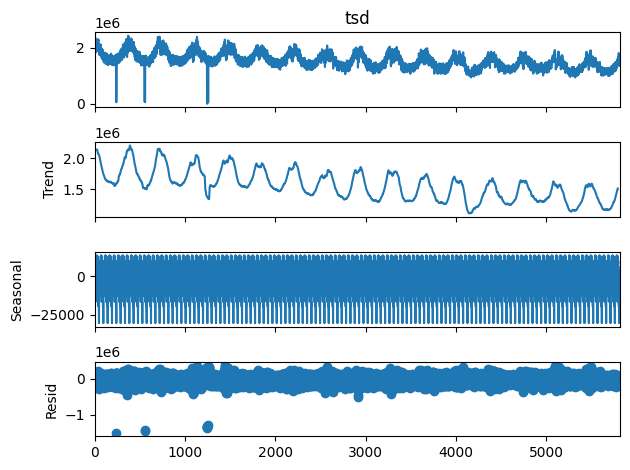

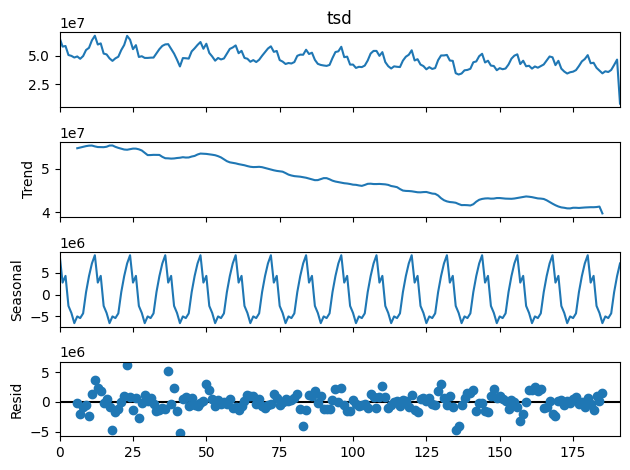

In [95]:
# Descomposición diaria
result = seasonal_decompose(df_diario["tsd"], model="additive", period=48) #porque las tomas son cada 30 min
result.plot()
plt.show()
#Aquí sí que hay periodo

#Descomposición anual
result = seasonal_decompose(df_mensual["tsd"], model="additive", period=12)
result.plot()
plt.show()

Por tanto, hay estacionalidad tanto diaria como anual.

Obtenemos la ACF para ver cada cuánto tiempo se repiten los patrones (autocorrelacicones significativas a ciertos lags).

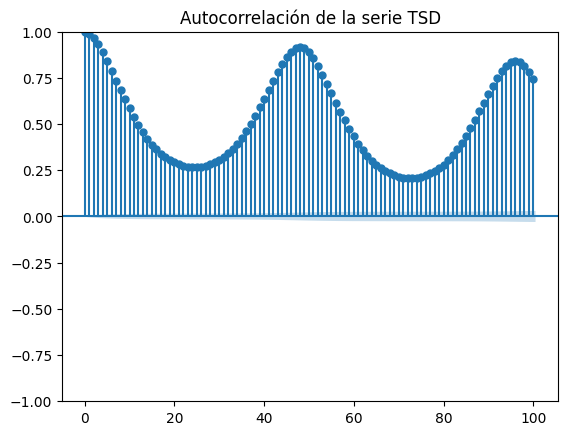

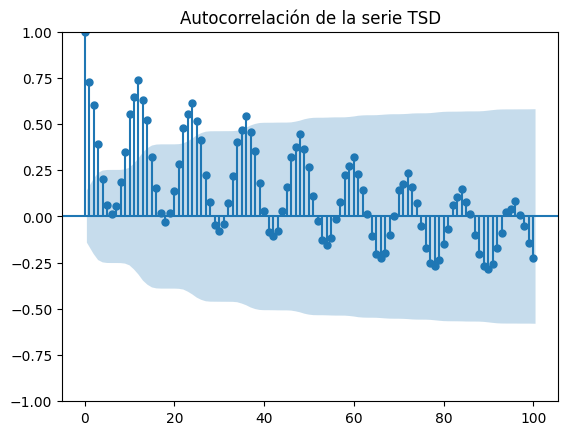

In [96]:
plot_acf(df5["tsd"].dropna(), lags=100)
plt.title("Autocorrelación de la serie TSD")
plt.show()


plot_acf(df_mensual["tsd"].dropna(), lags=100)
plt.title("Autocorrelación de la serie TSD")
plt.show()
#Periodos 48 y 12(en el anual, que en df5 equivale a periodo 17520)

In [97]:
# Creamos lags para patrones diario y mensual
# Cada 30 min -> 48 pasos diarios, 1440 pasos mensual (aprox 30 días)
daily_lags = [1, 2, 4, 8, 12, 24, 48]
#yearly_lags = [17520]
#El lag anual introduce muchos NaN y ruido, por eso lo hemos eliminado, porque a corto plazo nos estropea un poco el modelo ya que necesitamos dar muchos pasos
#Con el lag anual nos salen errores:
#MAE: 6498.06792859157
#MAPE: 25.543051466998595
#que no están mal, pero siguen siendo más grandes que los del prophet
all_lags = daily_lags #+ yearly_lags

for lag in all_lags:
    df5[f'lag_{lag}'] = df['tsd'].shift(lag)

# Eliminamos filas con NaN por los lags
df.dropna(inplace=True)

# Separamos features y target
X = df5[[f'lag_{lag}' for lag in all_lags]]
y = df5['tsd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entrenamos modelo XGBoost
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


/tmp/ipython-input-3760190185.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5[f'lag_{lag}'] = df['tsd'].shift(lag)
/tmp/ipython-input-3760190185.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5[f'lag_{lag}'] = df['tsd'].shift(lag)
/tmp/ipython-input-3760190185.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

A continuación vamos a graficar estas predicciones versus las del conjunto test reales.

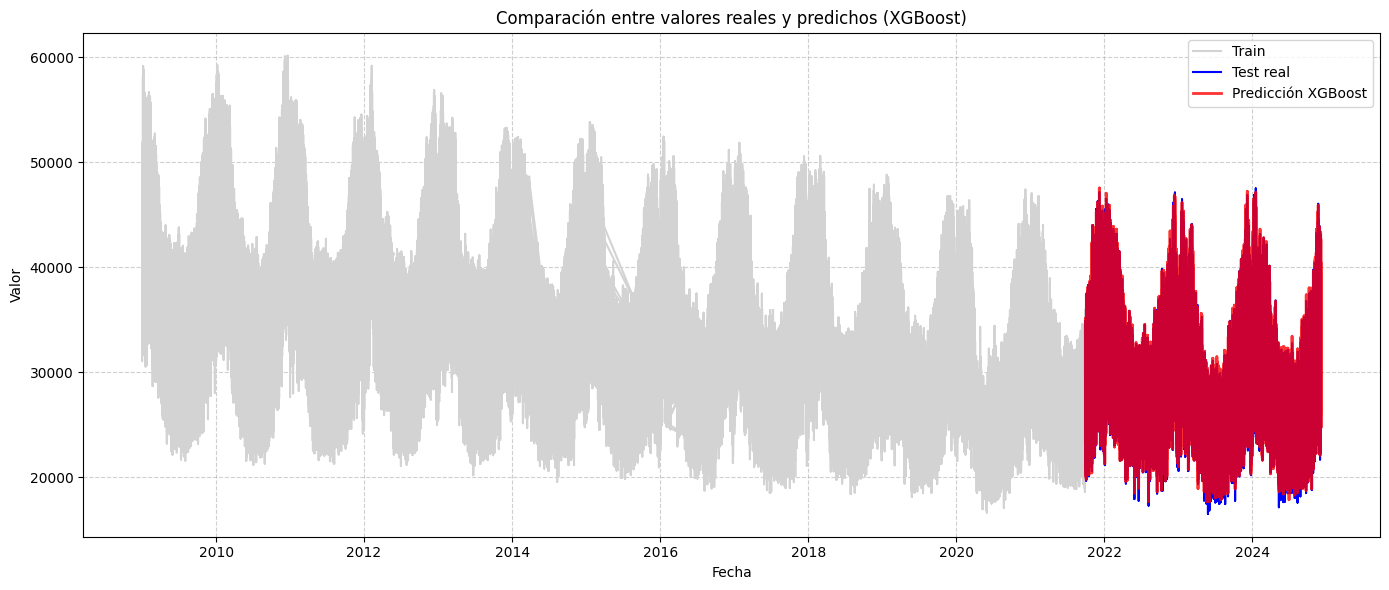

In [98]:
resultados = pd.DataFrame({
    'Fecha': df5.loc[y_test.index, 'settlement_date'],
    'Real': y_test.values,
    'Predicción': y_test_pred
}).set_index('Fecha')

# Gráficamos
plt.figure(figsize=(14, 6))
plt.plot(df5.loc[y_train.index, 'settlement_date'], y_train, color='lightgray', label='Train')
plt.plot(resultados.index, resultados['Real'], label='Test real', color='blue')
plt.plot(resultados.index, resultados['Predicción'], label='Predicción XGBoost', color='red', linewidth=2, alpha=0.8)
plt.title('Comparación entre valores reales y predichos (XGBoost)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Métricas de error

In [99]:
EVAL_METRICS_FUNC(y_train, y_train_pred, name="Train")

Metric evaluation results for Train:
  MAE: 312.7325655160041
  MAPE: 0.9590448903091405
  MSE:  258459.80
  R2:   0.996


In [100]:
EVAL_METRICS_FUNC(y_test, y_test_pred, name="Test")

Metric evaluation results for Test:
  MAE: 355.65385063526134
  MAPE: 1.2701352032094309
  MSE:  252618.81
  R2:   0.992


Hasta ahora, es el modelo que nos ha salido con errores más bajos, por lo que nos quedamos con este modelo para predecir a futuro. 😀✌

A continuación, con el modelo ya entrenado, predecimos a 12 meses ahead

In [101]:
# CONFIGURACIÓN
n_steps = 48 * 30*12   # por ejemplo, predecir los siguientes 12 meses
daily_lags = [1, 2, 4, 8, 12, 24, 48]
# yearly_lags = [17520]   # ⚠️ usa solo si tienes más de 1 año de datos reales
all_lags = daily_lags  # por ahora usamos solo los diarios

# PREPARAMOS VALORES INICIALES
# Últimos valores de la serie observada, necesarios para generar los primeros lags
max_lag = max(all_lags)
last_values = df5['tsd'].values[-max_lag:].tolist()

# PREDICCIÓN ITERATIVA CORRECTA
predictions = []

for step in range(n_steps):
    features = []

    # Creamos el vector de características con los lags actuales
    for lag in all_lags:
        if lag <= len(last_values):
            features.append(last_values[-lag])
        else:
            # Si aún no tenemos suficiente histórico, usamos el último valor conocido
            features.append(last_values[-1])

    features = np.array(features).reshape(1, -1)

    # Predecimos el siguiente valor
    pred = model.predict(features)[0]
    predictions.append(pred)

    # Actualizamos la lista de últimos valores con la nueva predicción
    last_values.append(pred)


# CREAMOS ÍNDICE DE FECHAS FUTURAS
future_index = pd.date_range(start='2025-01-01', periods=n_steps, freq='30T')
future_df = pd.DataFrame({'prediction': predictions}, index=future_index)

print(future_df.head(10))
print(future_df.tail(10))

                       prediction
2025-01-01 00:00:00  25950.537109
2025-01-01 00:30:00  25766.619141
2025-01-01 01:00:00  25569.185547
2025-01-01 01:30:00  25131.972656
2025-01-01 02:00:00  24915.246094
2025-01-01 02:30:00  24694.750000
2025-01-01 03:00:00  24638.949219
2025-01-01 03:30:00  24725.080078
2025-01-01 04:00:00  24938.101562
2025-01-01 04:30:00  25436.763672
                       prediction
2025-12-26 19:00:00  30830.533203
2025-12-26 19:30:00  33920.890625
2025-12-26 20:00:00  36062.847656
2025-12-26 20:30:00  37118.636719
2025-12-26 21:00:00  37369.371094
2025-12-26 21:30:00  37677.785156
2025-12-26 22:00:00  37718.781250
2025-12-26 22:30:00  37594.609375
2025-12-26 23:00:00  37700.148438
2025-12-26 23:30:00  37633.832031


/tmp/ipython-input-3613658668.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_index = pd.date_range(start='2025-01-01', periods=n_steps, freq='30T')


Por último, graficamos las predicciones a futuro (para 2025) empalmadas junto con la serie histórica.

[]

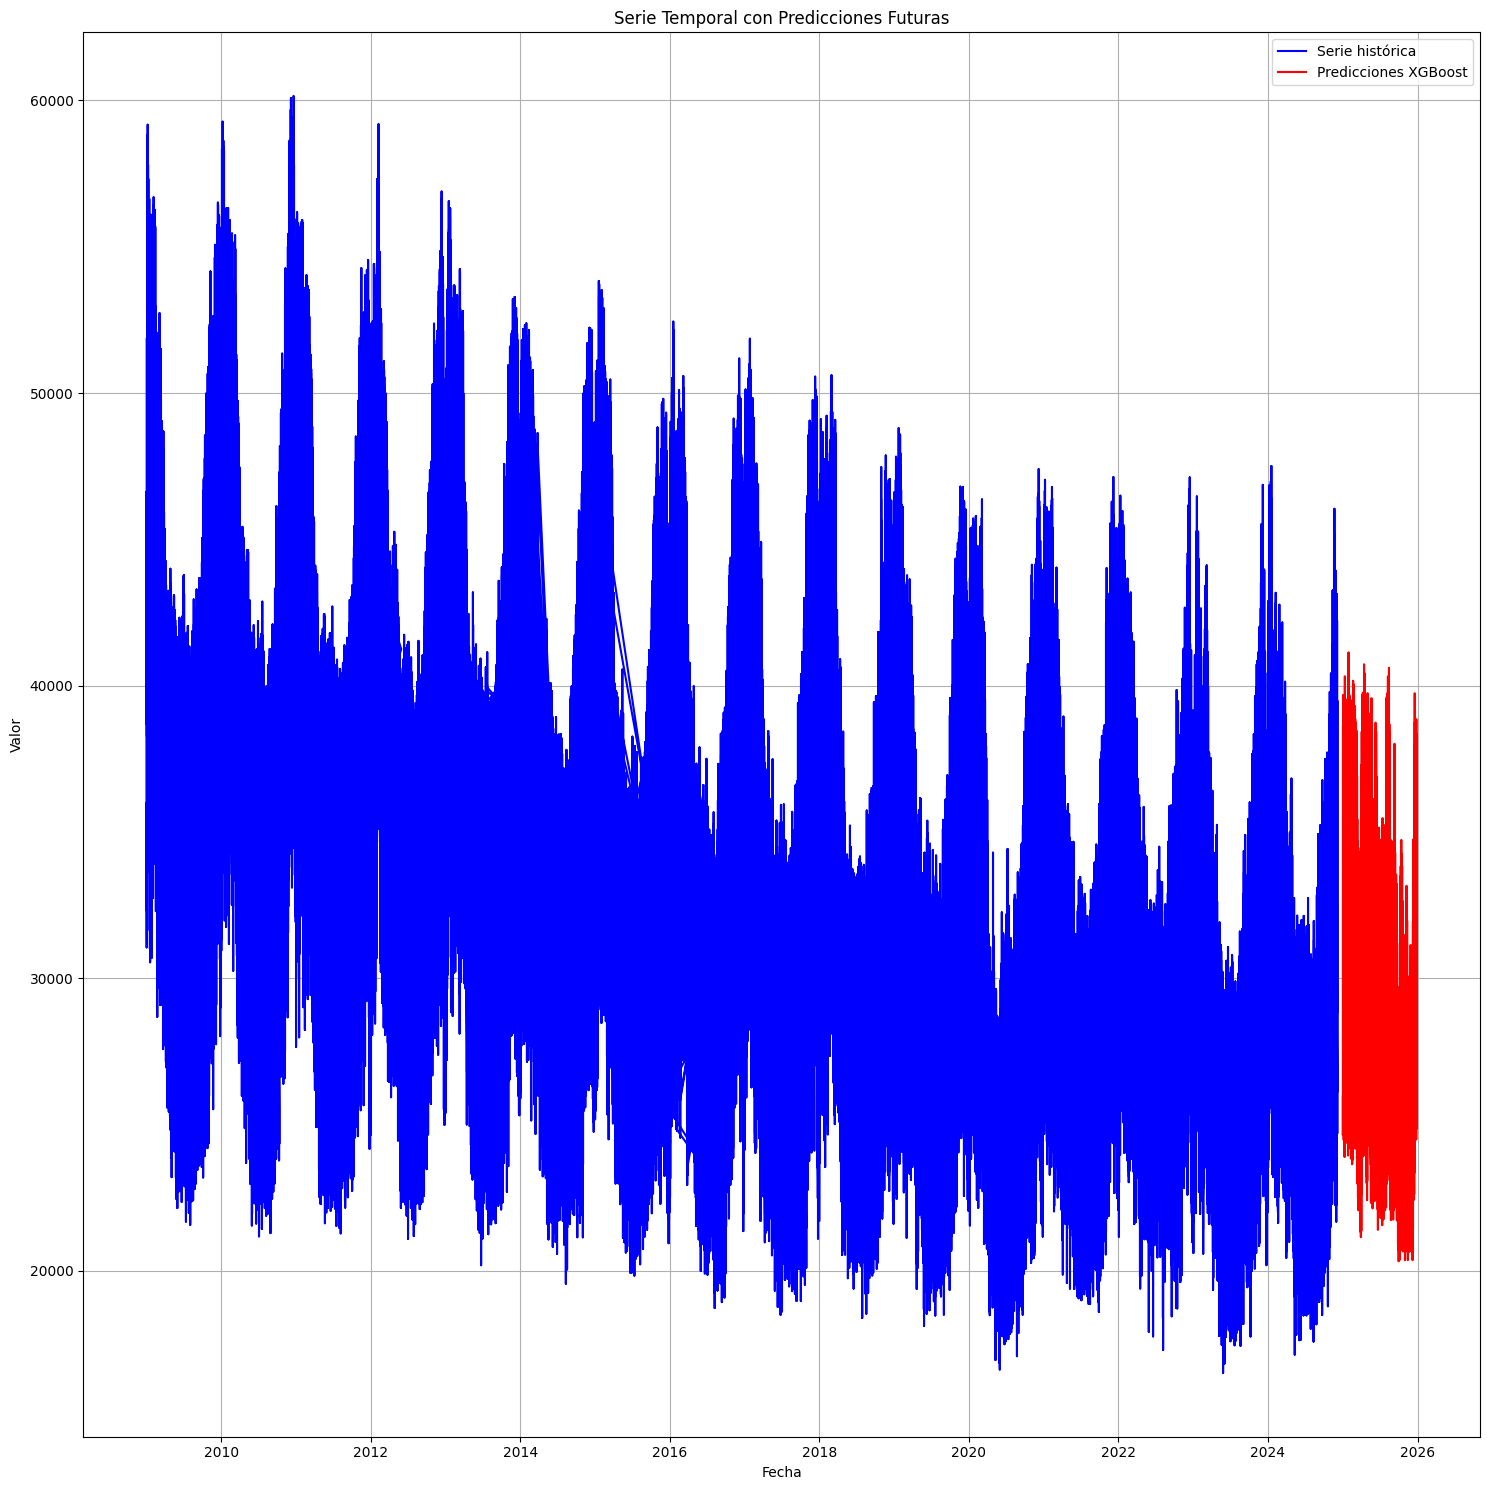

In [102]:
df5 = df[["settlement_date",
          "ds",
          "embedded_wind_generation",
          "embedded_wind_capacity",
          "embedded_solar_generation",
          "embedded_solar_capacity",
          "tsd"]]

# Graficamos serie histórica + predicciones diarias o mensuales
plt.figure(figsize=(15,15))
plt.plot(df5["settlement_date"], df5['tsd'], label='Serie histórica', color='blue')
plt.plot(future_df.index, future_df['prediction'], label='Predicciones XGBoost', color='red')
plt.title('Serie Temporal con Predicciones Futuras')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.plot()


## 4. Next steps

1. Realizar más modelos predictivos específicos para series temporales, como ARIMA, SARIMA o NeuralProphet.

2. Analizar formas de optimizar la relación entre la capacidad de producción y la energía realmente producida para las energías renovables.

3. Añadir al data set otras energías renovables que podrían tener un mejor funcionamento en UK, como la energía de las mareas (es una isla).

4. Analizar de manera más exhaustiva el porqué de la disminución de la demanda en días festivos.